## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from qutip.qip.operations import *
from qutip.qip.circuit import *
import sys
sys.path.append('../SimulationCode/')
from BlindGatesSimulation import *
from fiber_network import FiberNetwork
from SiVnodes import SiV
from SiVgates import *
from Plots import *
import pandas as pd
import glob


In [2]:
# colors for plots
c1 = '#F15F57'
c2 = '#F6851F'
c3 = '#FDB913'
c4 = '#743062'
c5 = '#C87EB5'
c6 = '#4CC0B3'
c7 = '#1C9AAA'

## Define SiVs 

In [3]:
# Create SiVs:

#Server A, G12
siv_a = SiV(kappa_in= (74.9 - 54.5)*(10**3), kappa_w= (54.5)*(10**3), g=5.6*(10**3), wCav = (0)*(10**3), 
             wSiv = -(479.8 -639.6)*(10**3), dwEl = 0.5*(10**3)) # G12
#Server B, B16
siv_b = SiV(kappa_in= (43.5 - 26.0)*(10**3), kappa_w= (26.0)*(10**3), g=8.5*(10**3), wCav = (0)*(10**3), 
             wSiv = -(804.9 -657.6)*(10**3), dwEl = -0.5*(10**3)) # B16

### Move the SiV to the desired contrast point

In [4]:
siv_b.set_contrast(50)
siv_a.set_contrast(15)

new contrast 52.71006248179681
new contrast 17.96184388854666


## Setup single Node experiments in B16

In [5]:
# Create Networks:
b16_network = FiberNetwork(siv_b) # this device is now in B16 fridge

# Create Simulation:
sim = BlindComputing(b16_network)

In [6]:
# Double check the contrast
contrast = siv_a.get_best_contrast()
print("Node A contrast = ", contrast)
contrast = siv_b.get_best_contrast()
print("Node B contrast = ", contrast)


Node A contrast =  17.96184388854666
Node B contrast =  52.71006248179681


### SiV related plots

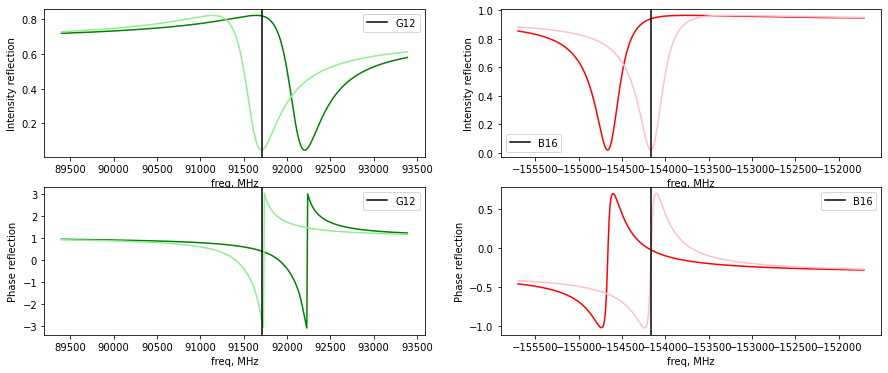

In [7]:
## Plot 
# generate plots of reflectivity

wl_A = siv_a.get_plotaxis()
wl_B = siv_b.get_plotaxis()

wl_read_optimum_A = siv_a.freq_optimum()
wl_read_optimum_B = siv_b.freq_optimum()

figure, ax = plt.subplots(2, 2, figsize=(15, 6))

ax[0,0].plot(wl_A, np.abs(siv_a.cav_refl(wl_A)['refl_refl'])**2, color = 'green')
ax[0,0].plot(wl_A, np.abs(siv_a.cav_refl(wl_A)['nonrefl_refl'])**2,color = 'lightgreen')
ax[0,0].set_xlabel('freq, MHz')
ax[0,0].set_ylabel('Intensity reflection')
ax[0,0].axvline(x = wl_read_optimum_A, color = 'black', label = 'G12')
ax[0,0].legend()

ax[0,1].plot(wl_B, np.abs(siv_b.cav_refl(wl_B)['refl_refl'])**2, color = 'red')
ax[0,1].plot(wl_B, np.abs(siv_b.cav_refl(wl_B)['nonrefl_refl'])**2, color = 'pink')
ax[0,1].set_xlabel('freq, MHz')
ax[0,1].set_ylabel('Intensity reflection')
ax[0,1].axvline(x = wl_read_optimum_B, color = 'black', label = 'B16')
ax[0,1].legend()

ax[1,0].plot(wl_A, np.angle(siv_a.cav_refl(wl_A)['refl_refl']), color = 'green')
ax[1,0].plot(wl_A, np.angle(siv_a.cav_refl(wl_A)['nonrefl_refl']),color = 'lightgreen')
ax[1,0].set_xlabel('freq, MHz')
ax[1,0].set_ylabel('Phase reflection')
ax[1,0].axvline(x = wl_read_optimum_A, color = 'black', label = 'G12')
ax[1,0].legend()

ax[1,1].plot(wl_B, np.angle(siv_b.cav_refl(wl_B)['refl_refl']), color = 'red')
ax[1,1].plot(wl_B, np.angle(siv_b.cav_refl(wl_B)['nonrefl_refl']), color = 'pink')
ax[1,1].set_xlabel('freq, MHz')
ax[1,1].set_ylabel('Phase reflection')
ax[1,1].axvline(x = wl_read_optimum_B, color = 'black', label = 'B16')
ax[1,1].legend()

plt.show()

## Single blind gates with electron as a function of phi

In [8]:
## Perfect single qubit gate with X+ init and multiple phi for Fig1 B

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real' #'real'
               }

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

mu = 0.05
# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1
phi1 = [0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8, 8*np.pi/8]
phi2 = 0
phi3 = 0

n_rounds = 2
n_col = 6

xp_array_angle_cl = np.empty((0, 2), dtype=float)
xp_array_angle_s = np.empty((0, 2), dtype=float)

for j in range(len(phi1)):

    xp_array = np.empty((0, n_col), dtype=float)
    rho_init_xp_array = np.empty((2, 2), dtype=float)

    phi1e = phi1[j]
    print("Phi angle = ", phi1e)
    for i in range(n_rounds): 
        rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
        rho_init_xp_array = np.append(rho_init_xp_array, rho_init_xp[0], axis = 0)
        xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
    # Average the data and save as a dict
    i = 0
    output_xp_mean_cl = np.mean(xp_array[:, i])
    output_xp_std_cl = np.std(xp_array[:, i], ddof=1)
    i = 3
    output_xp_mean_s = np.mean(xp_array[:, i])
    output_xp_std_s = np.std(xp_array[:, i], ddof=1)
    
    xp_array_angle_cl = np.append(xp_array_angle_cl, [[output_xp_mean_cl, output_xp_std_cl]], axis = 0)
    xp_array_angle_s = np.append(xp_array_angle_s, [[output_xp_mean_s, output_xp_std_s]], axis = 0)


Phi angle =  0
Phi angle =  0.39269908169872414
Phi angle =  0.7853981633974483
Phi angle =  1.1780972450961724
Phi angle =  1.5707963267948966
Phi angle =  1.9634954084936207
Phi angle =  2.356194490192345
Phi angle =  2.748893571891069
Phi angle =  3.141592653589793


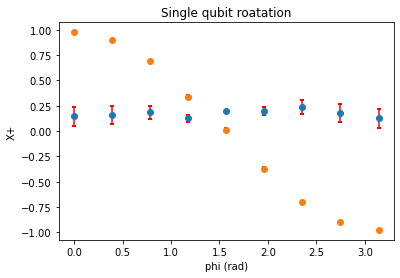

In [ ]:
# Create the plot
plt.errorbar(phi1,  xp_array_angle_s[: , 0], yerr= xp_array_angle_s[: , 1]/np.sqrt(n_rounds), fmt='o', ecolor='r', capsize=2, capthick=2, linestyle='None')
plt.errorbar(phi1,  xp_array_angle_cl[: , 0], yerr= xp_array_angle_cl[: , 1]/np.sqrt(n_rounds), fmt='o', ecolor='r', capsize=2, capthick=2, linestyle='None')

plt.xlabel('phi (rad)')
plt.ylabel('X+')
plt.yscale('linear')
plt.xscale('linear')
plt.title('Single qubit roatation') 

plt.show()

### Save data in a file

In [ ]:

data = {
    'phi': phi1,
    'xp_s': xp_array_angle_s[: , 0],
    'xp_s_err': xp_array_angle_s[: , 1]/np.sqrt(n_rounds),
    'xp_cl': xp_array_angle_cl[: , 0],
    'xp_cl_err': xp_array_angle_cl[: , 1]/np.sqrt(n_rounds),

}


df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_xpfinal_phis_contrast100_{n_rounds}pts_mu{mu}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

### Read the data from a file and plot

In [9]:
# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[0])

# Extract the columns you want to plot
phi = df['phi']
xp_s = df['xp_s']
xp_s_err= df['xp_s_err']
xp_cl = df['xp_cl']
xp_cl_err = df['xp_cl_err']


# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[1])

# Extract the columns you want to plot
phi_mu005 = df['phi']
xp_s_mu005 = df['xp_s']
xp_s_err_mu005 = df['xp_s_err']
xp_cl_mu005 = df['xp_cl']
xp_cl_err_mu005 = df['xp_cl_err']

# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[4])

# Extract the columns you want to plot
phi_contr4 = df['phi']
xp_s_contr4 = df['xp_s']
xp_s_err_contr4 = df['xp_s_err']
xp_cl_contr4 = df['xp_cl']
xp_cl_err_contr4 = df['xp_cl_err']


# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[2])

# Extract the columns you want to plot
phi_contr16 = df['phi']
xp_s_contr16 = df['xp_s']
xp_s_err_contr16 = df['xp_s_err']
xp_cl_contr16 = df['xp_cl']
xp_cl_err_contr16 = df['xp_cl_err']

file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[3])

# Extract the columns you want to plot
phi_contr100 = df['phi']
xp_s_contr100 = df['xp_s']
xp_s_err_contr100 = df['xp_s_err']
xp_cl_contr100 = df['xp_cl']
xp_cl_err_contr100 = df['xp_cl_err']




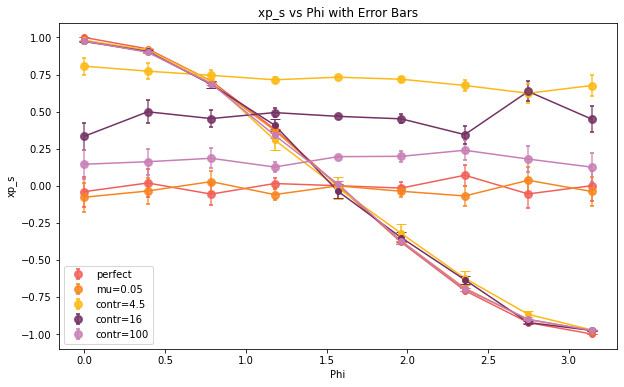

In [10]:
# Plot the data with error bars

plt.figure(figsize=(10, 6))
plt.errorbar(phi, xp_s, yerr=xp_s_err,  fmt='o',
             color=c1,           # Marker edge color
             markerfacecolor=c1, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c1,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='perfect')
plt.plot(phi, xp_s, color=c1)
plt.errorbar(phi, xp_cl, yerr=xp_cl_err,color=c1, fmt='o', capsize=5)
plt.plot(phi, xp_cl, color=c1)


plt.errorbar(phi_mu005, xp_s_mu005, yerr=xp_s_err_mu005,  fmt='o',
             color=c2,           # Marker edge color
             markerfacecolor=c2, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c2,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='mu=0.05')
plt.plot(phi_mu005, xp_s_mu005, color=c2)
plt.errorbar(phi_mu005, xp_cl_mu005, yerr=xp_cl_err_mu005,color=c2, fmt='o', capsize=5)
plt.plot(phi_mu005, xp_cl_mu005, color=c2)

# Plot the data with error bars
plt.errorbar(phi_contr4, xp_s_contr4, yerr=xp_s_err_contr4,  fmt='o',
             color=c3,           # Marker edge color
             markerfacecolor=c3, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c3,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='contr=4.5')
plt.plot(phi_contr4, xp_s_contr4, color=c3)

plt.errorbar(phi_contr4, xp_cl_contr4, yerr=xp_cl_err_contr4,color=c3, fmt='o', capsize=5)
plt.plot(phi_contr4, xp_cl_contr4, color=c3)

# Plot the data with error bars
plt.errorbar(phi_contr16, xp_s_contr16, yerr=xp_s_err_contr16,  fmt='o',
             color=c4,           # Marker edge color
             markerfacecolor=c4, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c4,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='contr=16')
plt.plot(phi_contr16, xp_s_contr16, color=c4)

plt.errorbar(phi_contr16, xp_cl_contr16, yerr=xp_cl_err_contr16,color=c4, fmt='o', capsize=5)
plt.plot(phi_contr16, xp_cl_contr16, color=c4)

# Plot the data with error bars
plt.errorbar(phi_contr100, xp_s_contr100, yerr=xp_s_err_contr100,  fmt='o',
             color=c5,           # Marker edge color
             markerfacecolor=c5, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c5,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='contr=100')
plt.plot(phi_contr100, xp_s_contr100, color=c5)


plt.errorbar(phi_contr100, xp_cl_contr100, yerr=xp_cl_err_contr100,color=c5, fmt='o', capsize=5)
plt.plot(phi_contr100, xp_cl_contr100, color=c5)

# Add labels and title
plt.xlabel('Phi')
plt.ylabel('xp_s')
plt.title('xp_s vs Phi with Error Bars')
plt.legend()

# Show the plot
plt.show()

## Single gate fidelities and blindness as a function of mu errors

In [10]:
mu_list = np.linspace(0.001, 1, 5)
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

siv_b.set_contrast(50)
actual_contrast = siv_b.get_best_contrast()
print(actual_contrast)

In [41]:
## Perfect single qubit gate with X+ init and multiple phi for Fig1 B

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real' #'real'
               }


# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1

n_rounds = 1000
n_col = 6

xp_array_angle_cl = np.empty((0, 2), dtype=float)
xp_array_angle_s = np.empty((0, 2), dtype=float)

rho_ave_cl_phi_mu = np.empty((0, 2, 2), dtype=complex)
rho_std_cl_phi_mu = np.empty((0, 2, 2), dtype=complex)

rho_ave_s_phi_mu = np.empty((0, 2, 2), dtype=complex)
rho_std_s_phi_mu = np.empty((0, 2, 2), dtype=complex)

rates_apd1_apd2_angle = np.empty((0, 2), dtype=float)


#phi list
for j in range(len(phi1)):
    phi1e = phi1[j]
    # my list
    rho_ave_cl_mu = np.empty((0, 2, 2), dtype=complex)
    rho_std_cl_mu = np.empty((0, 2, 2), dtype=complex)

    rho_ave_s_mu = np.empty((0, 2, 2), dtype=complex)
    rho_std_s_mu = np.empty((0, 2, 2), dtype=complex)

    rates_apd1_apd2 = np.empty((0, 2), dtype=float)


    for i in range(len(contrast_list)):
        mu = mu_list[i]
        xp_array = np.empty((0, n_col), dtype=float)
        rho_init_xp_array = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)

        print("Phi angle = ", phi1e)
        for i in range(n_rounds): 
            rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_init_xp_array = np.append(rho_init_xp_array, [rho_init_xp[0]], axis = 0)
            # which detector fired
            rho_click = np.append(rho_click, rho_init_xp[1])
            xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
        
        rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])
      
        ## servers density matrices
        # Calculate the mean rho matrix
        rho_ave_s = np.mean(rho_init_xp_array, axis=0)
        rho_ave_s_mu = np.append(rho_ave_s_mu, [rho_ave_s], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_s = np.std(rho_init_xp_array, axis=0)/n_rounds
        rho_std_s_mu = np.append(rho_std_s_mu, [rho_std_s], axis = 0)

        ## clients density matrices
        # Calculate the mean rho matrix
        rho_init_xp_array_corrected = np.empty((0, 2, 2), dtype=complex)

        for i in range(len(rho_init_xp_array)):
            rho_init_xp_array_corrected = np.append(rho_init_xp_array_corrected, [(qt.sigmaz()**(rho_click[i]))*rho_init_xp_array[i]*(qt.sigmaz()**(rho_click[i]))], axis = 0)
        
        rho_ave_cl = np.mean(rho_init_xp_array_corrected, axis=0)
        rho_ave_cl_mu = np.append(rho_ave_cl_mu, [rho_ave_cl], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_cl = np.std(rho_init_xp_array, axis=0)/n_rounds
        rho_std_cl_mu = np.append(rho_std_cl_mu, [rho_std_cl], axis = 0)

    rates_apd1_apd2_angle = np.append(rates_apd1_apd2_angle, [rates_apd1_apd2])

    rho_ave_s_phi_mu = np.append(rho_ave_s_phi_mu, rho_ave_s_mu, axis = 0)
    rho_std_s_phi_mu = np.append(rho_std_s_phi_mu, rho_std_s_mu, axis = 0)

    rho_ave_cl_phi_mu = np.append(rho_ave_cl_phi_mu, rho_ave_cl_mu, axis = 0)
    rho_std_cl_phi_mu = np.append(rho_std_cl_phi_mu, rho_std_cl_mu, axis = 0)


Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345


#### Save density matrices 

In [43]:
data = {
    'rho_ave_s': [rho_ave_s_phi_mu],
    'rho_std_s': [rho_std_s_phi_mu],
    'rho_ave_cl': [rho_ave_cl_phi_mu],
    'rho_std_cl': [rho_std_cl_phi_mu]

}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_rhos_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)


#### Retrieve the densities

In [51]:
# File path for the CSV file
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_rhos_phis_contrastperf_100pts_mulist_2024-08-17_18-13-51.csv'

# Read the DataFrame from the CSV file
df_loaded = pd.read_csv(file_path)

# Convert the string representations back to NumPy arrays
df_loaded['rho_ave_s'] = df_loaded['rho_ave_s'].apply(clean_and_convert_to_array)
df_loaded['rho_std_s'] = df_loaded['rho_std_s'].apply(clean_and_convert_to_array)
df_loaded['rho_ave_cl'] = df_loaded['rho_ave_cl'].apply(clean_and_convert_to_array)
df_loaded['rho_std_cl'] = df_loaded['rho_std_cl'].apply(clean_and_convert_to_array)


In [52]:

# Client's data
 
rho_ave_cl_0_mu = np.array(df_loaded['rho_ave_cl'][0][0:len(mu_list)])
rho_ave_cl_pi4_mu = np.array(df_loaded['rho_ave_cl'][0][len(mu_list):2*len(mu_list)])
rho_ave_cl_pi2_mu = np.array(df_loaded['rho_ave_cl'][0][2*len(mu_list):3*len(mu_list)])
rho_ave_cl_3pi4_mu = np.array(df_loaded['rho_ave_cl'][0][3*len(mu_list):])
rho_ave_cl_phis = [rho_ave_cl_0_mu, rho_ave_cl_pi4_mu, rho_ave_cl_pi2_mu, rho_ave_cl_3pi4_mu]

rho_std_cl_0_mu = np.array(df_loaded['rho_std_cl'][0][0:len(mu_list)])
rho_std_cl_pi4_mu = np.array(df_loaded['rho_std_cl'][0][len(mu_list):2*len(mu_list)])
rho_std_cl_pi2_mu = np.array(df_loaded['rho_std_cl'][0][2*len(mu_list):3*len(mu_list)])
rho_std_cl_3pi4_mu = np.array(df_loaded['rho_std_cl'][0][3*len(mu_list):])
rho_std_cl_phis = [rho_std_cl_0_mu, rho_std_cl_pi4_mu, rho_std_cl_pi2_mu, rho_std_cl_3pi4_mu]

# Server's data
 
rho_ave_s_0_mu = np.array(df_loaded['rho_ave_s'][0][0:len(mu_list)])
rho_ave_s_pi4_mu = np.array(df_loaded['rho_ave_s'][0][len(mu_list):2*len(mu_list)])
rho_ave_s_pi2_mu = np.array(df_loaded['rho_ave_s'][0][2*len(mu_list):3*len(mu_list)])
rho_ave_s_3pi4_mu = np.array(df_loaded['rho_ave_s'][0][3*len(mu_list):])
rho_ave_s_phis = [rho_ave_s_0_mu, rho_ave_s_pi4_mu, rho_ave_s_pi2_mu, rho_ave_s_3pi4_mu]

rho_std_s_0_mu = np.array(df_loaded['rho_std_s'][0][0:len(mu_list)])
rho_std_s_pi4_mu = np.array(df_loaded['rho_std_s'][0][len(mu_list):2*len(mu_list)])
rho_std_s_pi2_mu = np.array(df_loaded['rho_std_s'][0][2*len(mu_list):3*len(mu_list)])
rho_std_s_3pi4_mu = np.array(df_loaded['rho_std_s'][0][3*len(mu_list):])
rho_std_s_phis = [rho_std_s_0_mu, rho_std_s_pi4_mu, rho_std_s_pi2_mu, rho_std_s_3pi4_mu]

#### Fidelity of the gates

In [53]:
## compare to ideal results

fid_phi_mu =  np.empty((0, 2), dtype=float)
fid_err_phi_mu =  np.empty((0, 2), dtype=float)

for i in range(len(phi1)):
    U = rz(phi1[i])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_mu =  np.empty((0, 2), dtype=float)
    fid_err_mu =  np.empty((0, 2), dtype=float)
    for j in range(len(mu_list)):
        a = qt.Qobj(rho_ave_cl_phis[i][j])
        a_err = qt.Qobj(rho_std_cl_phis[i][j])
        fid = (qt.fidelity(a, el_rho_final_ideal))**2
        output = (calculate_fidelity_uncertainty(a, el_rho_final_ideal, a_err))
        fid_mu = np.append(fid_mu, [output[0]])
        fid_err_mu = np.append(fid_err_mu, [abs(output[1])])
    fid_phi_mu = np.append(fid_phi_mu, [fid_mu])
    fid_err_phi_mu = np.append(fid_err_phi_mu, [fid_err_mu])


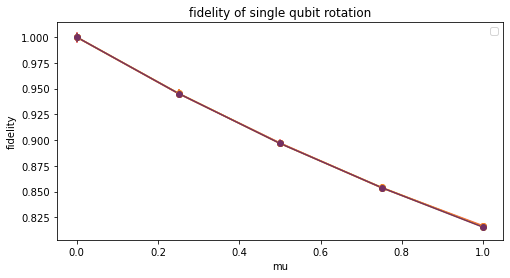

In [54]:

plt.figure(figsize=(8, 4))
plt.plot(mu_list, fid_phi_mu[0:len(mu_list)], color=c1)
plt.errorbar(mu_list,  fid_phi_mu[0:len(mu_list)], yerr= fid_err_phi_mu[0:len(mu_list)],  fmt='o', color=c1)
plt.plot(mu_list, fid_phi_mu[len(mu_list):2*len(mu_list)], color=c2)
plt.errorbar(mu_list,  fid_phi_mu[len(mu_list):2*len(mu_list)], yerr= fid_err_phi_mu[len(mu_list):2*len(mu_list)],  fmt='o', color=c2)
plt.plot(mu_list, fid_phi_mu[2*len(mu_list):3*len(mu_list)], color=c3)
plt.errorbar(mu_list,  fid_phi_mu[2*len(mu_list):3*len(mu_list)], yerr= fid_err_phi_mu[2*len(mu_list):3*len(mu_list)],  fmt='o', color=c3)
plt.plot(mu_list, fid_phi_mu[3*len(mu_list):], color=c4)
plt.errorbar(mu_list,  fid_phi_mu[3*len(mu_list):], yerr= fid_err_phi_mu[3*len(mu_list):],  fmt='o', color=c4)

#Add labels and title
plt.xlabel('mu')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation')
plt.legend()

# Show the plot
plt.show()

### Save the fidelity data if needed

In [84]:
data = {
    'fid': fid_phi_mu, 
    'yerr': fid_err_phi_mu,

}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_fiderr_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

data = {
    'phi': phi1, 
}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_philist_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

data = {
    'mu': mu_list, 

}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_mulist_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

### Read the fidelity data if needed

In [190]:
# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleRot_Init_xp_contrast52_perfMWgates_vsMuerrors_for4phiangles/*contrast52*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[2])
df_phi = pd.read_csv(csv_file[1])
df_mu = pd.read_csv(csv_file[0])

# Extract the columns you want to plot
phi = df_phi['phi']
mu = df_mu['mu']
fid = df['fid']
fid_err = df['yerr']


In [ ]:
#separate the results of the experiment 

mu_list  = mu
phi_list  = phi

rho_ave_cl_0_mu = fid_phi_mu[0:len(mu_list)]
rho_ave_cl_pi4_mu = fid_phi_mu[len(mu_list):2*len(mu_list)]
rho_ave_cl_pi2_mu = fid_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_ave_cl_3pi4_mu = fid_phi_mu[3*len(mu_list):]
rho_ave_cl_phis = [rho_ave_cl_0_mu, rho_ave_cl_pi4_mu, rho_ave_cl_pi2_mu, rho_ave_cl_3pi4_mu]

rho_std_cl_0_mu = fid_err_phi_mu[0:len(mu_list)]
rho_std_cl_pi4_mu = fid_err_phi_mu[len(mu_list):2*len(mu_list)]
rho_std_cl_pi2_mu = fid_err_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_std_cl_3pi4_mu = fid_err_phi_mu[3*len(mu_list):]
rho_std_cl_phis = [rho_std_cl_0_mu, rho_std_cl_pi4_mu, rho_std_cl_pi2_mu, rho_std_cl_3pi4_mu]


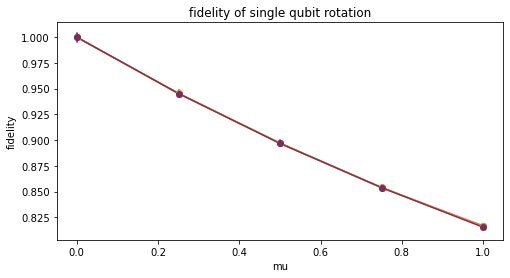

In [193]:

plt.figure(figsize=(8, 4))
plt.plot(mu_list, fid_phi_mu[0:len(mu_list)], color=c1)
plt.errorbar(mu_list,  fid_phi_mu[0:len(mu_list)], yerr= fid_err_phi_mu[0:len(mu_list)],  fmt='o', color=c1)
plt.plot(mu_list, fid_phi_mu[len(mu_list):2*len(mu_list)], color=c2)
plt.errorbar(mu_list,  fid_phi_mu[len(mu_list):2*len(mu_list)], yerr= fid_err_phi_mu[len(mu_list):2*len(mu_list)],  fmt='o', color=c2)
plt.plot(mu_list, fid_phi_mu[2*len(mu_list):3*len(mu_list)], color=c3)
plt.errorbar(mu_list,  fid_phi_mu[2*len(mu_list):3*len(mu_list)], yerr= fid_err_phi_mu[2*len(mu_list):3*len(mu_list)],  fmt='o', color=c3)
plt.plot(mu_list, fid_phi_mu[3*len(mu_list):], color=c4)
plt.errorbar(mu_list,  fid_phi_mu[3*len(mu_list):], yerr= fid_err_phi_mu[3*len(mu_list):],  fmt='o', color=c4)
#Add labels and title
plt.xlabel('mu')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation')

# Show the plot
plt.show()

#### Blindness of the gates

In [12]:
holevo_mu =  np.empty((0, 2), dtype=float)
holevo_err_mu =  np.empty((0, 2), dtype=float)

# Initialize empty arrays to accumulate results
rho_ave_mu = np.empty((0, 4, 2, 2), dtype=float)
rho_std_mu = np.empty((0, 4, 2, 2), dtype=float)

# Loop through mu_list and accumulate results 
for i in range(len(mu_list)):
    # Extract the ith element from each list and convert to an array
    rho_ave_onemu = np.array([lst[i] for lst in rho_ave_s_phis])
    rho_std_onemu = np.array([lst[i] for lst in rho_std_s_phis])

    # Append the arrays directly (as they should already have shape (2,))
    rho_ave_mu = np.append(rho_ave_mu, [rho_ave_onemu], axis=0)
    rho_std_mu = np.append(rho_std_mu, [rho_std_onemu], axis=0)

# calculate blindness as a function of mu
for j in range(len(mu_list)):
    holevo, holevo_err = sim.blindness_singleRot(rho_ave_mu[j], rho_std_mu[j], delta=1e-6)
    holevo_mu = np.append(holevo_mu, holevo)
    holevo_err_mu = np.append(holevo_err_mu, holevo_err)


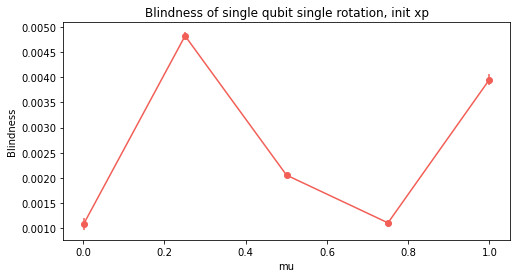

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(mu_list, holevo_mu, color=c1)
plt.errorbar(mu_list,  holevo_mu, yerr= np.abs(holevo_err_mu),  fmt='o', color=c1)

#Add labels and title
plt.xlabel('mu')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init xp')

# Show the plot
plt.show()

## Single gate fidelities and blindness as a function of contrast errors

In [53]:
# contrast_list = np.array([  4.,  12., 30., 50., 200.])
# contrast_list = np.array([ 3.,  7., 15., 25., 40., 60, 100, 150])
contrast_list = [1000, 5000, 10000, 50000]
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
# el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())

In [54]:
## Perfect single qubit gate with X+ init and multiple phi for Fig1 B

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect' #'real'
               }

# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1

n_rounds = 1000
n_col = 6
mu = 0.0002

xp_array_angle_cl = np.empty((0, 2), dtype=float)
xp_array_angle_s = np.empty((0, 2), dtype=float)


rho_ave_cl_phi_contr = np.empty((0, 2, 2), dtype=complex)
rho_std_cl_phi_contr = np.empty((0, 2, 2), dtype=complex)

rho_ave_s_phi_contr = np.empty((0, 2, 2), dtype=complex)
rho_std_s_phi_contr = np.empty((0, 2, 2), dtype=complex)

rates_apd1_apd2_angle = np.empty((0, 2), dtype=float)


#phi list
for j in range(len(phi1)):
    real_contrasts = np.empty((0, 2), dtype=float)
    phi1e = phi1[j]
    # my list
    rho_ave_cl_contr = np.empty((0, 2, 2), dtype=complex)
    rho_std_cl_contr = np.empty((0, 2, 2), dtype=complex)

    rho_ave_s_contr = np.empty((0, 2, 2), dtype=complex)
    rho_std_s_contr = np.empty((0, 2, 2), dtype=complex)
    rates_apd1_apd2 = np.empty((0, 2), dtype=float)

    for i in range(len(contrast_list)):
        # contrast = contrast_list[i]

        # move SiV in B16 to a new contrast location
        # siv_b.set_contrast(contrast)
        # actual_contrast = siv_b.get_best_contrast()
        # real_contrasts = np.append(real_contrasts, actual_contrast)

        xp_array = np.empty((0, n_col), dtype=float)
        rho_init_xp_array = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)

        print("Phi angle = ", phi1e)
        n_rounds = contrast_list[i]
        print(n_rounds)
        for i in range(n_rounds): 
            rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_init_xp_array = np.append(rho_init_xp_array, [rho_init_xp[0]], axis = 0)
            # which detector fired
            rho_click = np.append(rho_click, rho_init_xp[1])
            xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
            if i % 1000 == 0:
                print(i)
        rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])

        ## servers density matrices
        # Calculate the mean rho matrix
        rho_ave_s = np.mean(rho_init_xp_array, axis=0)
        rho_ave_s_contr = np.append(rho_ave_s_contr, [rho_ave_s], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_s = np.std(rho_init_xp_array, axis=0)
        #/n_rounds
        rho_std_s_contr = np.append(rho_std_s_contr, [rho_std_s], axis = 0)

        ## clients density matrices
        # Calculate the mean rho matrix
        rho_init_xp_array_corrected = np.empty((0, 2, 2), dtype=complex)

        for i in range(len(rho_init_xp_array)):
            rho_init_xp_array_corrected = np.append(rho_init_xp_array_corrected, [(qt.sigmaz()**(rho_click[i]))*rho_init_xp_array[i]*(qt.sigmaz()**(rho_click[i]))], axis = 0)
        
        rho_ave_cl = np.mean(rho_init_xp_array_corrected, axis=0)
        rho_ave_cl_contr = np.append(rho_ave_cl_contr, [rho_ave_cl], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_cl = np.std(rho_init_xp_array, axis=0)
        #/n_rounds
        rho_std_cl_contr = np.append(rho_std_cl_contr, [rho_std_cl], axis = 0)
    
    rates_apd1_apd2_angle = np.append(rates_apd1_apd2_angle, [rates_apd1_apd2])

    rho_ave_s_phi_contr = np.append(rho_ave_s_phi_contr, rho_ave_s_contr, axis = 0)
    rho_std_s_phi_contr = np.append(rho_std_s_phi_contr, rho_std_s_contr, axis = 0)

    rho_ave_cl_phi_contr = np.append(rho_ave_cl_phi_contr, rho_ave_cl_contr, axis = 0)
    rho_std_cl_phi_contr = np.append(rho_std_cl_phi_contr, rho_std_cl_contr, axis = 0)


Phi angle =  0
1000
0
Phi angle =  0
5000
0
1000
2000
3000
4000
Phi angle =  0
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Phi angle =  0
50000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
Phi angle =  0.7853981633974483
1000
0
Phi angle =  0.7853981633974483
5000
0
1000
2000
3000
4000
Phi angle =  0.7853981633974483
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Phi angle =  0.7853981633974483
50000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
Phi angle =  1.5707963267948966
1000
0
Phi angle =  

KeyboardInterrupt: 

#### Save density matrices 

In [339]:
import datetime

# Example complex matrices

# Convert the complex matrices to string representation
data = {
    'rho_ave_s': [str(rho_ave_s_phi_contr.tolist())],
    'rho_std_s': [str(rho_std_s_phi_contr.tolist())],  # Replace with actual std data
    'rho_ave_cl': [str(rho_ave_cl_phi_contr.tolist())],  # Replace with actual cl data
    'rho_std_cl': [str(rho_std_cl_phi_contr.tolist())]  # Replace with actual cl std data
}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_eff09_rhos_phis_{n_rounds}pts_mu{mu}_perfcontrast_perfMW_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)


#### Retrieve the densities

In [340]:
import ast

# File path for the input CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_eff09_rhos_phis_1000pts_mu0.0002_perfcontrast_perfMW_2024-08-25_00-59-37.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the string representations back into arrays
def string_to_array(string):
    # Use ast.literal_eval to safely evaluate the string to a list
    list_repr = ast.literal_eval(string)
    # Convert the list back to a NumPy array
    return np.array(list_repr, dtype=complex)

# Apply the conversion to the relevant columns
df['rho_ave_s'] = df['rho_ave_s'].apply(string_to_array)
df['rho_std_s'] = df['rho_std_s'].apply(string_to_array)
df['rho_ave_cl'] = df['rho_ave_cl'].apply(string_to_array)
df['rho_std_cl'] = df['rho_std_cl'].apply(string_to_array)

# Now you can access the arrays
rho_ave_s = df['rho_ave_s'][0]
rho_std_s = df['rho_std_s'][0]
rho_ave_cl = df['rho_ave_cl'][0]
rho_std_cl = df['rho_std_cl'][0]

In [342]:
# Client's data
 
rho_ave_cl_0_contr = np.array(rho_ave_cl[0:len(contrast_list)])
rho_ave_cl_pi4_contr = np.array(rho_ave_cl[len(contrast_list):2*len(contrast_list)])
rho_ave_cl_pi2_contr = np.array(rho_ave_cl[2*len(contrast_list):3*len(contrast_list)])
rho_ave_cl_3pi4_contr= np.array(rho_ave_cl[3*len(contrast_list):])
rho_ave_cl_phis = [rho_ave_cl_0_contr, rho_ave_cl_pi4_contr, rho_ave_cl_pi2_contr, rho_ave_cl_3pi4_contr]

rho_std_cl_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_cl_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_cl_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_cl_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_cl_phis = [rho_std_cl_0_contr, rho_std_cl_pi4_contr, rho_std_cl_pi2_contr, rho_std_cl_3pi4_contr]

# Server's data
 
rho_ave_s_0_contr = np.array(rho_ave_s[0:len(contrast_list)])
rho_ave_s_pi4_contr = np.array(rho_ave_s[len(contrast_list):2*len(contrast_list)])
rho_ave_s_pi2_contr = np.array(rho_ave_s[2*len(contrast_list):3*len(contrast_list)])
rho_ave_s_3pi4_contr = np.array(rho_ave_s[3*len(contrast_list):])
rho_ave_s_phis = [rho_ave_s_0_contr, rho_ave_s_pi4_contr, rho_ave_s_pi2_contr, rho_ave_s_3pi4_contr]

rho_std_s_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_s_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_s_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_s_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_s_phis = [rho_std_s_0_contr, rho_std_s_pi4_contr, rho_std_s_pi2_contr, rho_std_s_3pi4_contr]

#### Fidelity of the gates

In [343]:
## compare to ideal results

fid_phi_contr =  np.empty((0, 2), dtype=float)
fid_err_phi_contr =  np.empty((0, 2), dtype=float)

for i in range(len(phi1)):
    U = rz(phi1[i])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_contr =  np.empty((0, 2), dtype=float)
    fid_err_contr =  np.empty((0, 2), dtype=float)
    for j in range(len(contrast_list)):
        a = qt.Qobj(rho_ave_cl_phis[i][j])
        a_err = qt.Qobj(rho_std_cl_phis[i][j])
        fid = (qt.fidelity(a, el_rho_final_ideal))**2
        output = (calculate_fidelity_uncertainty(a, el_rho_final_ideal, a_err))
        fid_contr = np.append(fid_contr, [output[0]])
        fid_err_contr = np.append(fid_err_contr, [abs(output[1])])
    fid_phi_contr = np.append(fid_phi_contr, [fid_contr])
    fid_err_phi_contr = np.append(fid_err_phi_contr, [fid_err_contr])


In [346]:
real_contrasts = [2]

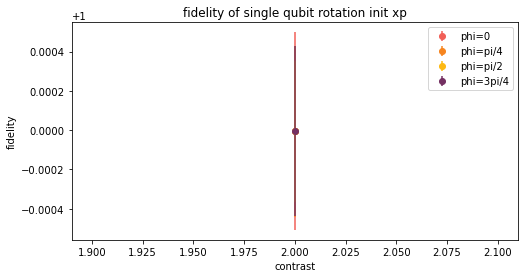

In [347]:

plt.figure(figsize=(8, 4))
plt.plot(real_contrasts, fid_phi_contr[0:len(contrast_list)], color=c1)
plt.errorbar(real_contrasts,  fid_phi_contr[0:len(contrast_list)], yerr= fid_err_phi_contr[0:len(contrast_list)],  fmt='o', color=c1, label='phi=0')
plt.plot(real_contrasts, fid_phi_contr[len(contrast_list):2*len(contrast_list)], color=c2)
plt.errorbar(real_contrasts,  fid_phi_contr[len(contrast_list):2*len(contrast_list)], yerr= fid_err_phi_contr[len(contrast_list):2*len(contrast_list)],  fmt='o', color=c2,  label='phi=pi/4')
plt.plot(real_contrasts, fid_phi_contr[2*len(contrast_list):3*len(contrast_list)], color=c3)
plt.errorbar(real_contrasts,  fid_phi_contr[2*len(contrast_list):3*len(contrast_list)], yerr= fid_err_phi_contr[2*len(contrast_list):3*len(contrast_list)],  fmt='o', color=c3, label='phi=pi/2')
plt.plot(real_contrasts, fid_phi_contr[3*len(contrast_list):], color=c4)
plt.errorbar(real_contrasts,  fid_phi_contr[3*len(contrast_list):], yerr= fid_err_phi_contr[3*len(contrast_list):],  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('contrast')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init xp')
plt.legend()

# Show the plot
plt.show()

#### Blindness of the gates

In [22]:
holevo_contr =  np.empty((0, 2), dtype=float)
holevo_err_contr =  np.empty((0, 2), dtype=float)

# Initialize empty arrays to accumulate results
rho_ave_contr = np.empty((0, 4, 2, 2), dtype=float)
rho_std_contr = np.empty((0, 4, 2, 2), dtype=float)

# Loop through mu_list and accumulate results 
for i in range(len(contrast_list)):
    # Extract the ith element from each list and convert to an array
    rho_ave_onec = np.array([lst[i] for lst in rho_ave_s_phis])
    rho_std_onec = np.array([lst[i] for lst in rho_std_s_phis])

    # Append the arrays directly (as they should already have shape (2,))
    rho_ave_contr = np.append(rho_ave_contr, [rho_ave_onec], axis=0)
    rho_std_contr = np.append(rho_std_contr, [rho_std_onec], axis=0)

# calculate blindness as a function of mu
for j in range(len(contrast_list)):
    holevo, holevo_err = blindness_singleRot(rho_ave_contr[j], rho_std_contr[j], delta=1e-6)
    holevo_contr = np.append(holevo_contr, holevo)
    holevo_err_contr = np.append(holevo_err_contr, holevo_err)


In [25]:
holevo_err_contr

array([0.00109902, 0.00110011, 0.00088222, 0.00067798])

In [24]:
holevo_contr

array([0.00052528, 0.0012999 , 0.00026891, 0.00010639])

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(real_contrasts, holevo_contr, color=c1)
plt.errorbar(real_contrasts,  holevo_contr, yerr= np.abs(holevo_err_contr),  fmt='o', color=c1)

#Add labels and title
plt.xlabel('Contrast')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init yp')

# Show the plot
plt.show()

NameError: name 'real_contrasts' is not defined

<Figure size 576x288 with 0 Axes>

In [372]:
fid_phi_contr

array([0.99998936, 0.99998947, 0.9999904 , 0.99999112, 0.9999918 ,
       0.92743872, 0.93116836, 0.96092055, 0.97808173, 0.98672413,
       0.8570768 , 0.85707682, 0.92309314, 0.95658543, 0.9738019 ,
       0.92907043, 0.92580697, 0.96117389, 0.97834692, 0.98679899])

In [373]:
fid_err_phi_contr

array([0.0012293 , 0.0012019 , 0.00152644, 0.00167022, 0.00167303,
       0.00095889, 0.00092919, 0.00112808, 0.00128718, 0.00133373,
       0.00032232, 0.0003137 , 0.00034959, 0.00037234, 0.00042208,
       0.00098745, 0.00099502, 0.00111797, 0.00127366, 0.00133014])

In [52]:

def blindness_singleRot(rho_phi_array, rho_std_phi_array, delta=1e-6):
    """
    Calculate the Holevo bound and its uncertainty given an array of density matrices and their standard deviations.
    
    Parameters:
    - rho_phi_array: List or array of density matrices corresponding to different phases.
    - rho_std_phi_array: List or array of standard deviations for each element in the density matrices.
    - delta: Small perturbation value for numerical derivative (default is 1e-6).
    
    Returns:
    - holevo: The calculated Holevo bound.
    - holevo_error: The uncertainty in the Holevo bound.
    """
    
    # Calculate the average density matrix
    rho_all = np.mean(rho_phi_array, axis=0)
    
    # Calculate the mean entropy of the individual density matrices
    mn = np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_phi_array])

    # Calculate the Holevo bound
    holevo = qt.entropy_vn(qt.Qobj(rho_all)) - mn

    # Initialize the error in the Holevo bound
    holevo_error = 0
    
    for k, rho in enumerate(rho_phi_array):
        partial_derivatives = np.zeros(rho.shape, dtype=complex)
        chi = holevo
        
        # Calculate the partial derivatives numerically
        for i in range(rho.shape[0]):
            for j in range(rho.shape[1]):
                perturbed_rho = rho.copy()
                
                # Apply perturbation and ensure Hermiticity
                delta_rho = np.zeros(rho.shape, dtype=complex)
                delta_rho[i, j] = delta
                delta_rho[j, i] = np.conj(delta_rho[i, j])  # Ensure Hermiticity
                
                # Adjust diagonal elements to preserve trace
                trace_adjustment = np.trace(delta_rho)
                delta_rho[i, i] -= trace_adjustment / rho.shape[0]
                
                perturbed_rho += delta_rho
                
                # Calculate perturbed average density matrix
                perturbed_rho_all = np.mean(
                    [perturbed_rho if idx == k else rho_phi_array[idx] for idx in range(len(rho_phi_array))],
                    axis=0
                )
                
                # Recalculate mean entropy
                perturbed_mn = np.mean([qt.entropy_vn(qt.Qobj(rho_phi)) for rho_phi in rho_phi_array])
                
                # Calculate perturbed Holevo bound
                perturbed_chi = qt.entropy_vn(qt.Qobj(perturbed_rho_all)) - perturbed_mn
                
                # Calculate the partial derivative
                partial_derivatives[i, j] = (perturbed_chi - chi) / delta
        
        # Sum the squared errors propagated through each partial derivative
        holevo_error += np.sum((np.abs(partial_derivatives) * rho_std_phi_array[k]) ** 2)
    
    # Take the square root to obtain the final uncertainty
    holevo_error = np.abs(np.sqrt(holevo_error))
    
    return holevo, holevo_error


### Make a plot against contrast from two datasets

#### Retrieve the densities

In [26]:
import ast

# File path for the input CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_eff09_rhos_phis_400pts_mu0.0002_contrast_DIFFlist_perfMW_2024-08-24_19-10-02.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the string representations back into arrays
def string_to_array(string):
    # Use ast.literal_eval to safely evaluate the string to a list
    list_repr = ast.literal_eval(string)
    # Convert the list back to a NumPy array
    return np.array(list_repr, dtype=complex)

# Apply the conversion to the relevant columns
df['rho_ave_s'] = df['rho_ave_s'].apply(string_to_array)
df['rho_std_s'] = df['rho_std_s'].apply(string_to_array)
df['rho_ave_cl'] = df['rho_ave_cl'].apply(string_to_array)
df['rho_std_cl'] = df['rho_std_cl'].apply(string_to_array)

# Now you can access the arrays
rho_ave_s = df['rho_ave_s'][0]
rho_std_s = df['rho_std_s'][0]
rho_ave_cl = df['rho_ave_cl'][0]
rho_std_cl = df['rho_std_cl'][0]



In [27]:
real_contrasts_new = np.array([  5.99716596,   5.99716596,  12.00413373,  22.03805164,
        37.18256904,  57.5169753 ,  97.72142048, 148.00658088])
real_contrasts_new_1 = np.array([  6.99570205,   9.01273982,  27.08043499,  47.19886866,
       197.04674604])
contrast_list = real_contrasts_new

In [28]:
# Client's data
 
rho_ave_cl_0_contr = np.array(rho_ave_cl[0:len(contrast_list)])
rho_ave_cl_pi4_contr = np.array(rho_ave_cl[len(contrast_list):2*len(contrast_list)])
rho_ave_cl_pi2_contr = np.array(rho_ave_cl[2*len(contrast_list):3*len(contrast_list)])
rho_ave_cl_3pi4_contr= np.array(rho_ave_cl[3*len(contrast_list):])
rho_ave_cl_phis = [rho_ave_cl_0_contr, rho_ave_cl_pi4_contr, rho_ave_cl_pi2_contr, rho_ave_cl_3pi4_contr]

rho_std_cl_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_cl_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_cl_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_cl_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_cl_phis = [rho_std_cl_0_contr, rho_std_cl_pi4_contr, rho_std_cl_pi2_contr, rho_std_cl_3pi4_contr]

# Server's data
 
rho_ave_s_0_contr = np.array(rho_ave_s[0:len(contrast_list)])
rho_ave_s_pi4_contr = np.array(rho_ave_s[len(contrast_list):2*len(contrast_list)])
rho_ave_s_pi2_contr = np.array(rho_ave_s[2*len(contrast_list):3*len(contrast_list)])
rho_ave_s_3pi4_contr = np.array(rho_ave_s[3*len(contrast_list):])
rho_ave_s_phis = [rho_ave_s_0_contr, rho_ave_s_pi4_contr, rho_ave_s_pi2_contr, rho_ave_s_3pi4_contr]

rho_std_s_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_s_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_s_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_s_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_s_phis = [rho_std_s_0_contr, rho_std_s_pi4_contr, rho_std_s_pi2_contr, rho_std_s_3pi4_contr]

In [29]:


# File path for the input CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_eff09_rhos_phis_400pts_mu0.0002_contrast_list_perfMW_2024-08-24_14-46-16.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the string representations back into arrays
def string_to_array(string):
    # Use ast.literal_eval to safely evaluate the string to a list
    list_repr = ast.literal_eval(string)
    # Convert the list back to a NumPy array
    return np.array(list_repr, dtype=complex)

# Apply the conversion to the relevant columns
df['rho_ave_s'] = df['rho_ave_s'].apply(string_to_array)
df['rho_std_s'] = df['rho_std_s'].apply(string_to_array)
df['rho_ave_cl'] = df['rho_ave_cl'].apply(string_to_array)
df['rho_std_cl'] = df['rho_std_cl'].apply(string_to_array)

# Now you can access the arrays
rho_ave_s = df['rho_ave_s'][0]
rho_std_s = df['rho_std_s'][0]
rho_ave_cl = df['rho_ave_cl'][0]
rho_std_cl = df['rho_std_cl'][0]



In [30]:
contrast_list = real_contrasts_new_1

In [31]:
# Client's data
 
rho_ave_cl_0_contr = np.array(rho_ave_cl[0:len(contrast_list)])
rho_ave_cl_pi4_contr = np.array(rho_ave_cl[len(contrast_list):2*len(contrast_list)])
rho_ave_cl_pi2_contr = np.array(rho_ave_cl[2*len(contrast_list):3*len(contrast_list)])
rho_ave_cl_3pi4_contr= np.array(rho_ave_cl[3*len(contrast_list):])
rho_ave_cl_phis1 = [rho_ave_cl_0_contr, rho_ave_cl_pi4_contr, rho_ave_cl_pi2_contr, rho_ave_cl_3pi4_contr]

rho_std_cl_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_cl_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_cl_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_cl_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_cl_phis1 = [rho_std_cl_0_contr, rho_std_cl_pi4_contr, rho_std_cl_pi2_contr, rho_std_cl_3pi4_contr]

# Server's data
 
rho_ave_s_0_contr = np.array(rho_ave_s[0:len(contrast_list)])
rho_ave_s_pi4_contr = np.array(rho_ave_s[len(contrast_list):2*len(contrast_list)])
rho_ave_s_pi2_contr = np.array(rho_ave_s[2*len(contrast_list):3*len(contrast_list)])
rho_ave_s_3pi4_contr = np.array(rho_ave_s[3*len(contrast_list):])
rho_ave_s_phis1 = [rho_ave_s_0_contr, rho_ave_s_pi4_contr, rho_ave_s_pi2_contr, rho_ave_s_3pi4_contr]

rho_std_s_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_s_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_s_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_s_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_s_phis1 = [rho_std_s_0_contr, rho_std_s_pi4_contr, rho_std_s_pi2_contr, rho_std_s_3pi4_contr]

#### Fidelity of the gates

In [32]:
## compare to ideal results

fid_phi_contr =  np.empty((0, 2), dtype=float)
fid_err_phi_contr =  np.empty((0, 2), dtype=float)

for i in range(len(phi1)):
    U = rz(phi1[i])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_contr =  np.empty((0, 2), dtype=float)
    fid_err_contr =  np.empty((0, 2), dtype=float)
    for j in range(len(real_contrasts_new)):
        a = qt.Qobj(rho_ave_cl_phis[i][j])
        a_err = qt.Qobj(rho_std_cl_phis[i][j])
        fid = (qt.fidelity(a, el_rho_final_ideal))**2
        output = (calculate_fidelity_uncertainty(a, el_rho_final_ideal, a_err))
        fid_contr = np.append(fid_contr, [output[0]])
        fid_err_contr = np.append(fid_err_contr, [abs(output[1])])
    fid_phi_contr = np.append(fid_phi_contr, [fid_contr])
    fid_err_phi_contr = np.append(fid_err_phi_contr, [fid_err_contr])


In [33]:
## compare to ideal results

fid_phi_contr1 =  np.empty((0, 2), dtype=float)
fid_err_phi_contr1 =  np.empty((0, 2), dtype=float)

for i in range(len(phi1)):
    U = rz(phi1[i])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_contr =  np.empty((0, 2), dtype=float)
    fid_err_contr =  np.empty((0, 2), dtype=float)
    for j in range(len(real_contrasts_new_1)):
        a = qt.Qobj(rho_ave_cl_phis1[i][j])
        a_err = qt.Qobj(rho_std_cl_phis1[i][j])
        fid = (qt.fidelity(a, el_rho_final_ideal))**2
        output = (calculate_fidelity_uncertainty(a, el_rho_final_ideal, a_err))
        fid_contr = np.append(fid_contr, [output[0]])
        fid_err_contr = np.append(fid_err_contr, [abs(output[1])])
    fid_phi_contr1 = np.append(fid_phi_contr1, [fid_contr])
    fid_err_phi_contr1 = np.append(fid_err_phi_contr1, [fid_err_contr])


In [34]:
real_contrasts_new_long = np.concatenate((real_contrasts_new, real_contrasts_new_1))
fid_phi_contr_long_1 = np.concatenate((fid_phi_contr[0:len(real_contrasts_new)], fid_phi_contr1[0:len(real_contrasts_new_1)]))
fid_phi_contr_long_2 = np.concatenate((fid_phi_contr[len(real_contrasts_new):2*len(real_contrasts_new)], fid_phi_contr1[len(real_contrasts_new_1):2*len(real_contrasts_new_1)]))
fid_phi_contr_long_3 = np.concatenate((fid_phi_contr[2*len(real_contrasts_new):3*len(real_contrasts_new)], fid_phi_contr1[2*len(real_contrasts_new_1):3*len(real_contrasts_new_1)]))
fid_phi_contr_long_4 = np.concatenate((fid_phi_contr[3*len(real_contrasts_new):], fid_phi_contr1[3*len(real_contrasts_new_1):]))

fid_err_phi_contr_long_1 = np.concatenate((fid_err_phi_contr[0:len(real_contrasts_new)], fid_err_phi_contr1[0:len(real_contrasts_new_1)]))
fid_err_phi_contr_long_2 = np.concatenate((fid_err_phi_contr[len(real_contrasts_new):2*len(real_contrasts_new)], fid_err_phi_contr1[len(real_contrasts_new_1):2*len(real_contrasts_new_1)]))
fid_err_phi_contr_long_3 = np.concatenate((fid_err_phi_contr[2*len(real_contrasts_new):3*len(real_contrasts_new)], fid_err_phi_contr1[2*len(real_contrasts_new_1):3*len(real_contrasts_new_1)]))
fid_err_phi_contr_long_4 = np.concatenate((fid_err_phi_contr[3*len(real_contrasts_new):], fid_err_phi_contr1[3*len(real_contrasts_new_1):]))



In [35]:
# sort arrays 

sorted_indices = np.argsort(real_contrasts_new_long)

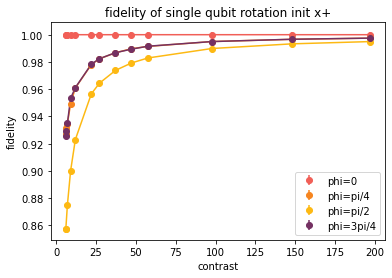

In [36]:

plt.figure(figsize=(6, 4))
plt.plot(real_contrasts_new_long[sorted_indices], fid_phi_contr_long_1[sorted_indices], color=c1)
plt.errorbar(real_contrasts_new_long,  fid_phi_contr_long_1, yerr= fid_err_phi_contr_long_1,  fmt='o', color=c1, label='phi=0')
plt.plot(real_contrasts_new_long[sorted_indices], fid_phi_contr_long_2[sorted_indices], color=c2)
plt.errorbar(real_contrasts_new_long,   fid_phi_contr_long_2, yerr= fid_err_phi_contr_long_2,  fmt='o', color=c2,  label='phi=pi/4')
plt.plot(real_contrasts_new_long[sorted_indices], fid_phi_contr_long_3[sorted_indices], color=c3)
plt.errorbar(real_contrasts_new_long,  fid_phi_contr_long_3, yerr= fid_err_phi_contr_long_3,  fmt='o', color=c3, label='phi=pi/2')
plt.plot(real_contrasts_new_long[sorted_indices], fid_phi_contr_long_4[sorted_indices], color=c4)
plt.errorbar(real_contrasts_new_long,  fid_phi_contr_long_4, yerr= fid_err_phi_contr_long_4,  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('contrast')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init x+')
plt.legend()

# Show the plot
plt.show()

In [37]:
real_contrasts_new = np.array([  5.99716596,   5.99716596,  12.00413373,  22.03805164,
        37.18256904,  57.5169753 ,  97.72142048, 148.00658088])
real_contrasts_new_1 = np.array([  6.99570205,   9.01273982,  27.08043499,  47.19886866,
       197.04674604])

real_contrasts_new_long = np.concatenate((real_contrasts_new, real_contrasts_new_1))

In [38]:

rates_oldcontr = np.array([8.28500746e-05, 1.68785173e-05, 7.70206600e-05, 1.95121438e-05,
       6.06310109e-05, 2.79980863e-05, 5.54797567e-05, 3.10432222e-05,
       4.74909716e-05, 3.58055702e-05, 7.31887637e-05, 2.65398281e-05,
       6.85987327e-05, 2.79340710e-05, 5.58520297e-05, 3.27770674e-05,
       5.19011091e-05, 3.46218698e-05, 4.57796842e-05, 3.75168576e-05,
       4.98642959e-05, 4.98642959e-05, 4.82664019e-05, 4.82664019e-05,
       4.43145486e-05, 4.43145486e-05, 4.32614895e-05, 4.32614895e-05,
       4.16482709e-05, 4.16482709e-05, 2.65398281e-05, 7.31887637e-05,
       2.79340710e-05, 6.85987327e-05, 3.27770674e-05, 5.58520297e-05,
       3.46218698e-05, 5.19011091e-05, 3.75168576e-05, 4.57796842e-05])
rates_oldcontr1 = np.array([8.66017307e-05, 1.54107562e-05, 8.66017307e-05, 1.54107562e-05,
       7.18713734e-05, 2.19037767e-05, 6.25774576e-05, 2.69718233e-05,
       5.70301461e-05, 3.01882925e-05, 5.34708292e-05, 3.23159834e-05,
       5.02877323e-05, 3.42046157e-05, 4.83881072e-05, 3.53100890e-05,
       7.61760539e-05, 2.58364330e-05, 7.61760539e-05, 2.58364330e-05,
       6.45537882e-05, 2.92213618e-05, 5.73631332e-05, 3.21861477e-05,
       5.30992476e-05, 3.41191909e-05, 5.03727737e-05, 3.54140388e-05,
       4.79324144e-05, 3.65599336e-05, 4.64728758e-05, 3.72253205e-05,
       5.10062434e-05, 5.10062434e-05, 5.10062434e-05, 5.10062434e-05,
       4.68875750e-05, 4.68875750e-05, 4.47746405e-05, 4.47746405e-05,
       4.36092193e-05, 4.36092193e-05, 4.28934063e-05, 4.28934063e-05,
       4.22461740e-05, 4.22461740e-05, 4.18490981e-05, 4.18490981e-05,
       2.58364330e-05, 7.61760539e-05, 2.58364330e-05, 7.61760539e-05,
       2.92213618e-05, 6.45537882e-05, 3.21861477e-05, 5.73631332e-05,
       3.41191909e-05, 5.30992476e-05, 3.54140388e-05, 5.03727737e-05,
       3.65599336e-05, 4.79324144e-05, 3.72253205e-05, 4.64728758e-05])


In [223]:
7.70206600e-05/1.95121438e-05

3.9473192074363452

In [236]:
ratios = []
length = len(rates_oldcontr)
# Ensure even length by ignoring the last element if length is odd
for i in range(0, length, 2):
    numerator = rates_oldcontr[i]
    denominator = rates_oldcontr[i + 1]
    if denominator == 0:
        ratio = None  # or handle accordingly
    else:
        ratio = numerator / denominator
    ratios.append(ratio)

ratios1 = []
length = len(rates_oldcontr1)
# Ensure even length by ignoring the last element if length is odd
for i in range(0, length, 2):
    numerator = rates_oldcontr1[i]
    denominator = rates_oldcontr1[i + 1]
    if denominator == 0:
        ratio = None  # or handle accordingly
    else:
        ratio = numerator / denominator
    ratios1.append(ratio)

In [251]:
ratios1 = ratios[:len(real_contrasts_new_1)]
ratios2 = ratios[len(real_contrasts_new_1):2*len(real_contrasts_new_1)]
ratios3 = ratios[2*len(real_contrasts_new_1):3*len(real_contrasts_new_1)]
ratios4 = ratios[3*len(real_contrasts_new_1):]

ratios11 = ratios1[:len(real_contrasts_new)]
ratios12 = ratios1[len(real_contrasts_new):2*len(real_contrasts_new)]
ratios13 = ratios1[2*len(real_contrasts_new):3*len(real_contrasts_new)]
ratios14 = ratios1[3*len(real_contrasts_new):]

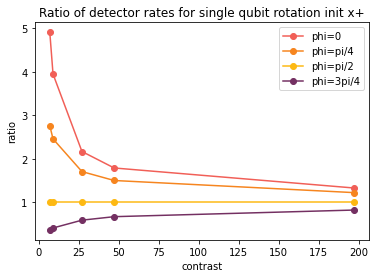

In [259]:
plt.figure(figsize=(6, 4))
plt.plot(real_contrasts_new_1, ratios1, marker='o', color=c1, label='phi=0')
plt.plot(real_contrasts_new_1, ratios2, marker='o', color=c2, label='phi=pi/4')
plt.plot(real_contrasts_new_1, ratios3, marker='o', color=c3, label='phi=pi/2')
plt.plot(real_contrasts_new_1, ratios4, marker='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('contrast')
plt.ylabel('ratio')
plt.title('Ratio of detector rates for single qubit rotation init x+')
plt.legend()

# Show the plot
plt.show()

#### Blindness of the gates

In [48]:
holevo_contr =  np.empty((0, 2), dtype=float)
holevo_err_contr =  np.empty((0, 2), dtype=float)

# Initialize empty arrays to accumulate results
rho_ave_contr = np.empty((0, 4, 2, 2), dtype=float)
rho_std_contr = np.empty((0, 4, 2, 2), dtype=float)

# Loop through mu_list and accumulate results 
for i in range(len(real_contrasts_new)):
    # Extract the ith element from each list and convert to an array
    rho_ave_onec = np.array([lst[i] for lst in rho_ave_s_phis])
    rho_std_onec = np.array([lst[i] for lst in rho_std_s_phis])
    # Append the arrays directly (as they should already have shape (2,))
    rho_ave_contr = np.append(rho_ave_contr, [rho_ave_onec], axis=0)
    rho_std_contr = np.append(rho_std_contr, [rho_std_onec], axis=0)

# calculate blindness as a function of mu
for j in range(len(real_contrasts_new)):
    holevo, holevo_err = blindness_singleRot(rho_ave_contr[j], rho_std_contr[j], delta=1e-6)

    # Calculate the average density matrix
    rho_all = np.mean(rho_ave_contr[j], axis=0)

    # Calculate the mean entropy of the individual density matrices
    mn = np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_contr[j]])

    # Calculate the Holevo bound
    holevo1 = qt.entropy_vn(qt.Qobj(rho_all)) - mn

    holevo_contr = np.append(holevo_contr, holevo)
    holevo_err_contr = np.append(holevo_err_contr, holevo_err)


In [49]:
holevo_contr1 =  np.empty((0, 2), dtype=float)
holevo_err_contr1 =  np.empty((0, 2), dtype=float)

# Initialize empty arrays to accumulate results
rho_ave_contr = np.empty((0, 4, 2, 2), dtype=float)
rho_std_contr = np.empty((0, 4, 2, 2), dtype=float)

# Loop through mu_list and accumulate results 
for i in range(len(real_contrasts_new_1)):
    # Extract the ith element from each list and convert to an array
    rho_ave_onec = np.array([lst[i] for lst in rho_ave_s_phis1])
    rho_std_onec = np.array([lst[i] for lst in rho_std_s_phis1])

    # Append the arrays directly (as they should already have shape (2,))
    rho_ave_contr = np.append(rho_ave_contr, [rho_ave_onec], axis=0)
    rho_std_contr = np.append(rho_std_contr, [rho_std_onec], axis=0)

# calculate blindness as a function of mu
for j in range(len(real_contrasts_new_1)):
    holevo, holevo_err = blindness_singleRot(rho_ave_contr[j], rho_std_contr[j], delta=1e-6)

    # Calculate the average density matrix
    rho_all = np.mean(rho_ave_contr[j], axis=0)

    # Calculate the mean entropy of the individual density matrices
    mn = np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_contr[j]])

    # Calculate the Holevo bound
    holevo1 = qt.entropy_vn(qt.Qobj(rho_all)) - mn

    holevo_contr1 = np.append(holevo_contr1, holevo)
    holevo_err_contr1 = np.append(holevo_err_contr1, holevo_err)


In [50]:
# combine
real_contrasts_new_long = np.concatenate((real_contrasts_new, real_contrasts_new_1))
holevo_contr_long = np.concatenate((holevo_contr, holevo_contr1))
holevo_err_contr_long = np.concatenate((holevo_err_contr, holevo_err_contr1))

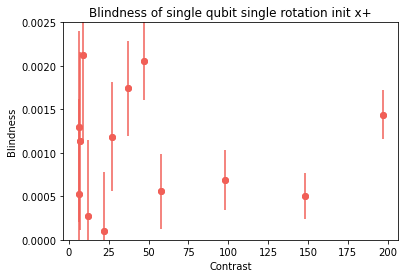

In [51]:
plt.figure(figsize=(6, 4))
plt.plot(real_contrasts_new_long[sorted_indices], holevo_contr_long[sorted_indices], 'o', color=c1)
plt.errorbar(real_contrasts_new_long[sorted_indices],  holevo_contr_long[sorted_indices], yerr= np.abs(holevo_err_contr_long[sorted_indices]),  fmt='o', color=c1)

#Add labels and title
plt.xlabel('Contrast')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation init x+')
plt.ylim(0, 0.0025)

# Show the plot
plt.show()


## Single gate fidelities and blindness as a function of MW errors

In [434]:
fidel_val1 = {'pi': 0.98,
                'pi_half': 0.6
                }
set_mw_fidelities(fid = 'real', noise = 0, fidel_val =fidel_val1)

{'pi': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
 Qobj data =
 [[ 0.14231484 -0.98982144]
  [ 0.98982144  0.14231484]],
 'pi_half': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
 Qobj data =
 [[ 0.98768834 -0.15643447]
  [ 0.15643447  0.98768834]]}

In [442]:
mw_list = np.linspace(1, 0.6, 10)
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
# el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())

In [444]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect', #'real'
                'mw': 'real', # or perfect
                'mw_noise': 0, #(0 is stable or 1 noisy)
                'mw_fid_num': 1
               }

# move SiV in B16 to a new contrast location
# contrast = 50
# siv_b.set_contrast(contrast)
# actual_contrast = siv_b.get_best_contrast()

cluster_state_length = 1

n_rounds = 1
n_col = 6
mu = 0.0002

xp_array_angle_cl = np.empty((0, 2), dtype=float)
xp_array_angle_s = np.empty((0, 2), dtype=float)


rho_ave_cl_phi_mw = np.empty((0, 2, 2), dtype=complex)
rho_std_cl_phi_mw = np.empty((0, 2, 2), dtype=complex)

rho_ave_s_phi_mw = np.empty((0, 2, 2), dtype=complex)
rho_std_s_phi_mw = np.empty((0, 2, 2), dtype=complex)

#phi list
for j in range(len(phi1)):
    real_contrasts = np.empty((0, 2), dtype=float)
    phi1e = phi1[j]
    # my list
    rho_ave_cl_mw = np.empty((0, 2, 2), dtype=complex)
    rho_std_cl_mw = np.empty((0, 2, 2), dtype=complex)

    rho_ave_s_mw = np.empty((0, 2, 2), dtype=complex)
    rho_std_s_mw = np.empty((0, 2, 2), dtype=complex)

    for i in range(len(mw_list)):
        imperfections['mw_fid_num']=mw_list[i]
        xp_array = np.empty((0, n_col), dtype=float)
        rho_init_xp_array = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)

        print("Phi angle = ", phi1e)
        for i in range(n_rounds): 
            rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_init_xp_array = np.append(rho_init_xp_array, [rho_init_xp[0]], axis = 0)
            # which detector fired
            rho_click = np.append(rho_click, rho_init_xp[1])
            xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
                
        ## servers density matrices
        # Calculate the mean rho matrix
        rho_ave_s = np.mean(rho_init_xp_array, axis=0)
        rho_ave_s_mw = np.append(rho_ave_s_mw, [rho_ave_s], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_s = np.std(rho_init_xp_array, axis=0)/n_rounds
        rho_std_s_mw = np.append(rho_std_s_mw, [rho_std_s], axis = 0)

        ## clients density matrices
        # Calculate the mean rho matrix
        rho_init_xp_array_corrected = np.empty((0, 2, 2), dtype=complex)

        for i in range(len(rho_init_xp_array)):
            rho_init_xp_array_corrected = np.append(rho_init_xp_array_corrected, [(qt.sigmaz()**(rho_click[i]))*rho_init_xp_array[i]*(qt.sigmaz()**(rho_click[i]))], axis = 0)
        
        rho_ave_cl = np.mean(rho_init_xp_array_corrected, axis=0)
        rho_ave_cl_mw = np.append(rho_ave_cl_mw, [rho_ave_cl], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_cl = np.std(rho_init_xp_array, axis=0)/n_rounds
        rho_std_cl_mw = np.append(rho_std_cl_mw, [rho_std_cl], axis = 0)

    
    rho_ave_s_phi_mw = np.append(rho_ave_s_phi_mw, rho_ave_s_mw, axis = 0)
    rho_std_s_phi_mw = np.append(rho_std_s_phi_mw, rho_std_s_mw, axis = 0)

    rho_ave_cl_phi_mw = np.append(rho_ave_cl_phi_mw, rho_ave_cl_mw, axis = 0)
    rho_std_cl_phi_mw = np.append(rho_std_cl_phi_mw, rho_std_cl_mw, axis = 0)


Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  0.7853981633974483
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  1.5707963267948966
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345
Phi angle =  2.356194490192345
Phi angle =  2.356194490

#### Save density matrices 

In [464]:
import datetime

# Example complex matrices

# Convert the complex matrices to string representation
data = {
    'rho_ave_s': [str(rho_ave_s_phi_mw.tolist())],
    'rho_std_s': [str(rho_std_s_phi_mw.tolist())],  # Replace with actual std data
    'rho_ave_cl': [str(rho_ave_cl_phi_mw.tolist())],  # Replace with actual cl data
    'rho_std_cl': [str(rho_std_cl_phi_mw.tolist())]  # Replace with actual cl std data
}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_rhos_phis_{n_rounds}pts_mu{mu}_mw_list_perfcontr_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)


#### Retrieve the densities

In [465]:
import ast

# File path for the input CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_rhos_phis_1pts_mu0.0002_mw_list_perfcontr_2024-08-27_17-51-49.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the string representations back into arrays
def string_to_array(string):
    # Use ast.literal_eval to safely evaluate the string to a list
    list_repr = ast.literal_eval(string)
    # Convert the list back to a NumPy array
    return np.array(list_repr, dtype=complex)

# Apply the conversion to the relevant columns
df['rho_ave_s'] = df['rho_ave_s'].apply(string_to_array)
df['rho_std_s'] = df['rho_std_s'].apply(string_to_array)
df['rho_ave_cl'] = df['rho_ave_cl'].apply(string_to_array)
df['rho_std_cl'] = df['rho_std_cl'].apply(string_to_array)

# Now you can access the arrays
rho_ave_s = df['rho_ave_s'][0]
rho_std_s = df['rho_std_s'][0]
rho_ave_cl = df['rho_ave_cl'][0]
rho_std_cl = df['rho_std_cl'][0]



In [467]:
# Client's data
 
rho_ave_cl_0_mw = np.array(rho_ave_cl[0:len(mw_list)])
rho_ave_cl_pi4_mw = np.array(rho_ave_cl[len(mw_list):2*len(mw_list)])
rho_ave_cl_pi2_mw = np.array(rho_ave_cl[2*len(mw_list):3*len(mw_list)])
rho_ave_cl_3pi4_mw = np.array(rho_ave_cl[3*len(mw_list):])
rho_ave_cl_phis = [rho_ave_cl_0_mw, rho_ave_cl_pi4_mw, rho_ave_cl_pi2_mw, rho_ave_cl_3pi4_mw]

rho_std_cl_0_mw = np.array(rho_std_cl[0:len(mw_list)])
rho_std_cl_pi4_mw = np.array(rho_std_cl[len(mw_list):2*len(mw_list)])
rho_std_cl_pi2_mw = np.array(rho_std_cl[2*len(mw_list):3*len(mw_list)])
rho_std_cl_3pi4_mw = np.array(rho_std_cl[3*len(mw_list):])
rho_std_cl_phis = [rho_std_cl_0_mw, rho_std_cl_pi4_mw, rho_std_cl_pi2_mw, rho_std_cl_3pi4_mw]

# Server's data
 
rho_ave_s_0_mw = np.array(rho_ave_s[0:len(mw_list)])
rho_ave_s_pi4_mw = np.array(rho_ave_s[len(mw_list):2*len(mw_list)])
rho_ave_s_pi2_mw = np.array(rho_ave_s[2*len(mw_list):3*len(mw_list)])
rho_ave_s_3pi4_mw = np.array(rho_ave_s[3*len(mw_list):])
rho_ave_s_phis = [rho_ave_s_0_mw, rho_ave_s_pi4_mw, rho_ave_s_pi2_mw, rho_ave_s_3pi4_mw]

rho_std_s_0_mw = np.array(rho_std_cl[0:len(mw_list)])
rho_std_s_pi4_mw = np.array(rho_std_cl[len(mw_list):2*len(mw_list)])
rho_std_s_pi2_mw = np.array(rho_std_cl[2*len(mw_list):3*len(mw_list)])
rho_std_s_3pi4_mw = np.array(rho_std_cl[3*len(mw_list):])
rho_std_s_phis = [rho_std_s_0_mw, rho_std_s_pi4_mw, rho_std_s_pi2_mw, rho_std_s_3pi4_mw]

#### Fidelity of the gates

In [469]:
## compare to ideal results

fid_phi_mw =  np.empty((0, 2), dtype=float)
fid_err_phi_mw =  np.empty((0, 2), dtype=float)

for i in range(len(phi1)):
    U = rz(phi1[i])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_mw =  np.empty((0, 2), dtype=float)
    fid_err_mw =  np.empty((0, 2), dtype=float)
    for j in range(len(mw_list)):
        a = qt.Qobj(rho_ave_cl_phis[i][j])
        a_err = qt.Qobj(rho_std_cl_phis[i][j])
        fid = (qt.fidelity(a, el_rho_final_ideal))**2
        output = (calculate_fidelity_uncertainty(a, el_rho_final_ideal, a_err))
        fid_mw = np.append(fid_mw, [output[0]])
        fid_err_mw = np.append(fid_err_mw, [abs(output[1])])
    fid_phi_mw = np.append(fid_phi_mw, [fid_mw])
    fid_err_phi_mw = np.append(fid_err_phi_mw, [fid_err_mw])


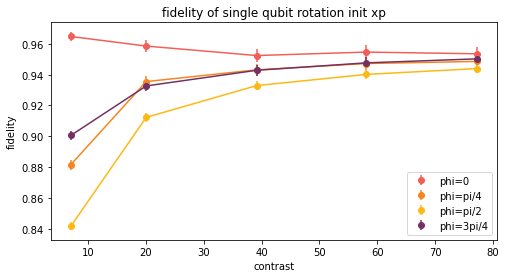

In [ ]:

plt.figure(figsize=(8, 4))
plt.plot(mw_list, fid_phi_contr[0:len(contrast_list)], color=c1)
plt.errorbar(mw_list,  fid_phi_contr[0:len(contrast_list)], yerr= fid_err_phi_contr[0:len(contrast_list)],  fmt='o', color=c1, label='phi=0')
plt.plot(mw_list, fid_phi_contr[len(contrast_list):2*len(contrast_list)], color=c2)
plt.errorbar(real_contrasts,  fid_phi_contr[len(contrast_list):2*len(contrast_list)], yerr= fid_err_phi_contr[len(contrast_list):2*len(contrast_list)],  fmt='o', color=c2,  label='phi=pi/4')
plt.plot(real_contrasts, fid_phi_contr[2*len(contrast_list):3*len(contrast_list)], color=c3)
plt.errorbar(real_contrasts,  fid_phi_contr[2*len(contrast_list):3*len(contrast_list)], yerr= fid_err_phi_contr[2*len(contrast_list):3*len(contrast_list)],  fmt='o', color=c3, label='phi=pi/2')
plt.plot(real_contrasts, fid_phi_contr[3*len(contrast_list):], color=c4)
plt.errorbar(real_contrasts,  fid_phi_contr[3*len(contrast_list):], yerr= fid_err_phi_contr[3*len(contrast_list):],  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('contrast')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init xp')
plt.legend()

# Show the plot
plt.show()

#### Blindness of the gates

In [ ]:
holevo_contr =  np.empty((0, 2), dtype=float)
holevo_err_contr =  np.empty((0, 2), dtype=float)

# Initialize empty arrays to accumulate results
rho_ave_contr = np.empty((0, 4, 2, 2), dtype=float)
rho_std_contr = np.empty((0, 4, 2, 2), dtype=float)

# Loop through mu_list and accumulate results 
for i in range(len(contrast_list)):
    # Extract the ith element from each list and convert to an array
    rho_ave_onec = np.array([lst[i] for lst in rho_ave_s_phis])
    rho_std_onec = np.array([lst[i] for lst in rho_std_s_phis])

    # Append the arrays directly (as they should already have shape (2,))
    rho_ave_contr = np.append(rho_ave_contr, [rho_ave_onec], axis=0)
    rho_std_contr = np.append(rho_std_contr, [rho_std_onec], axis=0)

# calculate blindness as a function of mu
for j in range(len(contrast_list)):
    holevo, holevo_err = sim.blindness_singleRot(rho_ave_contr[j], rho_std_contr[j], delta=1e-6)
    holevo_contr = np.append(holevo_contr, holevo)
    holevo_err_contr = np.append(holevo_err_contr, holevo_err)


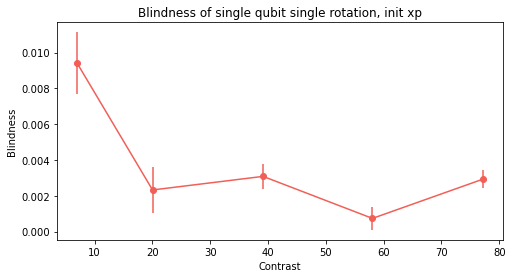

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(real_contrasts, holevo_contr, color=c1)
plt.errorbar(real_contrasts,  holevo_contr, yerr= np.abs(holevo_err_contr),  fmt='o', color=c1)

#Add labels and title
plt.xlabel('Contrast')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init xp')

# Show the plot
plt.show()

In [ ]:
## Single gate fidelities and blindness as a function of contrast errors
contrast_list = np.linspace(4, 80, 5)
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
## Perfect single qubit gate with X+ init and multiple phi for Fig1 B

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real' #'real'
               }

# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1

n_rounds = 100
n_col = 6
mu = 0.3

xp_array_angle_cl = np.empty((0, 2), dtype=float)
xp_array_angle_s = np.empty((0, 2), dtype=float)


rho_ave_cl_phi_contr = np.empty((0, 2, 2), dtype=complex)
rho_std_cl_phi_contr = np.empty((0, 2, 2), dtype=complex)

rho_ave_s_phi_contr = np.empty((0, 2, 2), dtype=complex)
rho_std_s_phi_contr = np.empty((0, 2, 2), dtype=complex)

#phi list
for j in range(len(phi1)):
    real_contrasts = np.empty((0, 2), dtype=float)
    phi1e = phi1[j]
    # my list
    rho_ave_cl_contr = np.empty((0, 2, 2), dtype=complex)
    rho_std_cl_contr = np.empty((0, 2, 2), dtype=complex)

    rho_ave_s_contr = np.empty((0, 2, 2), dtype=complex)
    rho_std_s_contr = np.empty((0, 2, 2), dtype=complex)

    for i in range(len(contrast_list)):
        contrast = contrast_list[i]

        # move SiV in B16 to a new contrast location
        siv_b.set_contrast(contrast)
        actual_contrast = siv_b.get_best_contrast()
        real_contrasts = np.append(real_contrasts, actual_contrast)

        xp_array = np.empty((0, n_col), dtype=float)
        rho_init_xp_array = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)

        print("Phi angle = ", phi1e)
        for i in range(n_rounds): 
            rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_init_xp_array = np.append(rho_init_xp_array, [rho_init_xp[0]], axis = 0)
            # which detector fired
            rho_click = np.append(rho_click, rho_init_xp[1])
            xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
                
        ## servers density matrices
        # Calculate the mean rho matrix
        rho_ave_s = np.mean(rho_init_xp_array, axis=0)
        rho_ave_s_contr = np.append(rho_ave_s_contr, [rho_ave_s], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_s = np.std(rho_init_xp_array, axis=0)/n_rounds
        rho_std_s_contr = np.append(rho_std_s_contr, [rho_std_s], axis = 0)

        ## clients density matrices
        # Calculate the mean rho matrix
        rho_init_xp_array_corrected = np.empty((0, 2, 2), dtype=complex)

        for i in range(len(rho_init_xp_array)):
            rho_init_xp_array_corrected = np.append(rho_init_xp_array_corrected, [(qt.sigmaz()**(rho_click[i]))*rho_init_xp_array[i]*(qt.sigmaz()**(rho_click[i]))], axis = 0)
        
        rho_ave_cl = np.mean(rho_init_xp_array_corrected, axis=0)
        rho_ave_cl_contr = np.append(rho_ave_cl_contr, [rho_ave_cl], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_cl = np.std(rho_init_xp_array, axis=0)/n_rounds
        rho_std_cl_contr = np.append(rho_std_cl_contr, [rho_std_cl], axis = 0)

    
    rho_ave_s_phi_contr = np.append(rho_ave_s_phi_contr, rho_ave_s_contr, axis = 0)
    rho_std_s_phi_contr = np.append(rho_std_s_phi_contr, rho_std_s_contr, axis = 0)

    rho_ave_cl_phi_contr = np.append(rho_ave_cl_phi_contr, rho_ave_cl_contr, axis = 0)
    rho_std_cl_phi_contr = np.append(rho_std_cl_phi_contr, rho_std_cl_contr, axis = 0)

#### Save density matrices 
import datetime

# Example complex matrices

# Convert the complex matrices to string representation
data = {
    'rho_ave_s': [str(rho_ave_s_phi_contr.tolist())],
    'rho_std_s': [str(rho_std_s_phi_contr.tolist())],  # Replace with actual std data
    'rho_ave_cl': [str(rho_ave_cl_phi_contr.tolist())],  # Replace with actual cl data
    'rho_std_cl': [str(rho_std_cl_phi_contr.tolist())]  # Replace with actual cl std data
}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_rhos_phis_{n_rounds}pts_mu0_2_contrast_list_perfMW_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

#### Retrieve the densities
import ast

# File path for the input CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_rhos_phis_100pts_mu0_2_contrast_list_perfMW_2024-08-21_10-25-27.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the string representations back into arrays
def string_to_array(string):
    # Use ast.literal_eval to safely evaluate the string to a list
    list_repr = ast.literal_eval(string)
    # Convert the list back to a NumPy array
    return np.array(list_repr, dtype=complex)

# Apply the conversion to the relevant columns
df['rho_ave_s'] = df['rho_ave_s'].apply(string_to_array)
df['rho_std_s'] = df['rho_std_s'].apply(string_to_array)
df['rho_ave_cl'] = df['rho_ave_cl'].apply(string_to_array)
df['rho_std_cl'] = df['rho_std_cl'].apply(string_to_array)

# Now you can access the arrays
rho_ave_s = df['rho_ave_s'][0]
rho_std_s = df['rho_std_s'][0]
rho_ave_cl = df['rho_ave_cl'][0]
rho_std_cl = df['rho_std_cl'][0]


# Client's data
 
rho_ave_cl_0_contr = np.array(rho_ave_cl[0:len(contrast_list)])
rho_ave_cl_pi4_contr = np.array(rho_ave_cl[len(contrast_list):2*len(contrast_list)])
rho_ave_cl_pi2_contr = np.array(rho_ave_cl[2*len(contrast_list):3*len(contrast_list)])
rho_ave_cl_3pi4_contr= np.array(rho_ave_cl[3*len(contrast_list):])
rho_ave_cl_phis = [rho_ave_cl_0_contr, rho_ave_cl_pi4_contr, rho_ave_cl_pi2_contr, rho_ave_cl_3pi4_contr]

rho_std_cl_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_cl_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_cl_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_cl_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_cl_phis = [rho_std_cl_0_contr, rho_std_cl_pi4_contr, rho_std_cl_pi2_contr, rho_std_cl_3pi4_contr]

# Server's data
 
rho_ave_s_0_contr = np.array(rho_ave_s[0:len(contrast_list)])
rho_ave_s_pi4_contr = np.array(rho_ave_s[len(contrast_list):2*len(contrast_list)])
rho_ave_s_pi2_contr = np.array(rho_ave_s[2*len(contrast_list):3*len(contrast_list)])
rho_ave_s_3pi4_contr = np.array(rho_ave_s[3*len(contrast_list):])
rho_ave_s_phis = [rho_ave_s_0_contr, rho_ave_s_pi4_contr, rho_ave_s_pi2_contr, rho_ave_s_3pi4_contr]

rho_std_s_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_s_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_s_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_s_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_s_phis = [rho_std_s_0_contr, rho_std_s_pi4_contr, rho_std_s_pi2_contr, rho_std_s_3pi4_contr]
#### Fidelity of the gates
## compare to ideal results

fid_phi_contr =  np.empty((0, 2), dtype=float)
fid_err_phi_contr =  np.empty((0, 2), dtype=float)

for i in range(len(phi1)):
    U = rz(phi1[i])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_contr =  np.empty((0, 2), dtype=float)
    fid_err_contr =  np.empty((0, 2), dtype=float)
    for j in range(len(contrast_list)):
        a = qt.Qobj(rho_ave_cl_phis[i][j])
        a_err = qt.Qobj(rho_std_cl_phis[i][j])
        fid = (qt.fidelity(a, el_rho_final_ideal))**2
        output = (calculate_fidelity_uncertainty(a, el_rho_final_ideal, a_err))
        fid_contr = np.append(fid_contr, [output[0]])
        fid_err_contr = np.append(fid_err_contr, [abs(output[1])])
    fid_phi_contr = np.append(fid_phi_contr, [fid_contr])
    fid_err_phi_contr = np.append(fid_err_phi_contr, [fid_err_contr])


plt.figure(figsize=(8, 4))
plt.plot(real_contrasts, fid_phi_contr[0:len(contrast_list)], color=c1)
plt.errorbar(real_contrasts,  fid_phi_contr[0:len(contrast_list)], yerr= fid_err_phi_contr[0:len(contrast_list)],  fmt='o', color=c1, label='phi=0')
plt.plot(real_contrasts, fid_phi_contr[len(contrast_list):2*len(contrast_list)], color=c2)
plt.errorbar(real_contrasts,  fid_phi_contr[len(contrast_list):2*len(contrast_list)], yerr= fid_err_phi_contr[len(contrast_list):2*len(contrast_list)],  fmt='o', color=c2,  label='phi=pi/4')
plt.plot(real_contrasts, fid_phi_contr[2*len(contrast_list):3*len(contrast_list)], color=c3)
plt.errorbar(real_contrasts,  fid_phi_contr[2*len(contrast_list):3*len(contrast_list)], yerr= fid_err_phi_contr[2*len(contrast_list):3*len(contrast_list)],  fmt='o', color=c3, label='phi=pi/2')
plt.plot(real_contrasts, fid_phi_contr[3*len(contrast_list):], color=c4)
plt.errorbar(real_contrasts,  fid_phi_contr[3*len(contrast_list):], yerr= fid_err_phi_contr[3*len(contrast_list):],  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('contrast')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation')
plt.legend()

# Show the plot
plt.show()
#### Blindness of the gates
holevo_contr =  np.empty((0, 2), dtype=float)
holevo_err_contr =  np.empty((0, 2), dtype=float)

# Initialize empty arrays to accumulate results
rho_ave_contr = np.empty((0, 4, 2, 2), dtype=float)
rho_std_contr = np.empty((0, 4, 2, 2), dtype=float)

# Loop through mu_list and accumulate results 
for i in range(len(contrast_list)):
    # Extract the ith element from each list and convert to an array
    rho_ave_onec = np.array([lst[i] for lst in rho_ave_s_phis])
    rho_std_onec = np.array([lst[i] for lst in rho_std_s_phis])

    # Append the arrays directly (as they should already have shape (2,))
    rho_ave_contr = np.append(rho_ave_contr, [rho_ave_onec], axis=0)
    rho_std_contr = np.append(rho_std_contr, [rho_std_onec], axis=0)

# calculate blindness as a function of mu
for j in range(len(contrast_list)):
    holevo, holevo_err = sim.blindness_singleRot(rho_ave_contr[j], rho_std_contr[j], delta=1e-6)
    holevo_contr = np.append(holevo_contr, holevo)
    holevo_err_contr = np.append(holevo_err_contr, holevo_err)

plt.figure(figsize=(8, 4))
plt.plot(real_contrasts, holevo_contr, color=c1)
plt.errorbar(real_contrasts,  holevo_contr, yerr= np.abs(holevo_err_contr),  fmt='o', color=c1)

#Add labels and title
plt.xlabel('Contrast')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init xp')

# Show the plot
plt.show()

## Extra

In [ ]:
## Perfect single qubit gates with all init states and all final states

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect' #'real'
               }

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_xm  = qt.ket2dm((qt.basis(2,0)- qt.basis(2,1)).unit())
el_initial_yp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())
el_initial_ym  = qt.ket2dm((qt.basis(2,0)- 1j*qt.basis(2,1)).unit())
el_initial_zp  = qt.ket2dm((qt.basis(2,0)).unit())
el_initial_zm  = qt.ket2dm((qt.basis(2,1)).unit())

mu = 0.01
# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1
phi1 = 0
phi2 = 0
phi3 = 0

n_rounds = 40
n_col = 6

xp_array = np.empty((0, n_col), dtype=float)
xm_array = np.empty((0, n_col), dtype=float)
yp_array = np.empty((0, n_col), dtype=float)
ym_array = np.empty((0, n_col), dtype=float)
zp_array = np.empty((0, n_col), dtype=float)
zm_array = np.empty((0, n_col), dtype=float)

rho_init_xp_array = np.empty((2, 2), dtype=float)
rho_init_xm_array = np.empty((2, 2), dtype=float)
rho_init_yp_array = np.empty((2, 2), dtype=float)
rho_init_ym_array = np.empty((2, 2), dtype=float)
rho_init_zp_array = np.empty((2, 2), dtype=float)
rho_init_zm_array = np.empty((2, 2), dtype=float)

for i in range(n_rounds): 
    rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_xm, Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s = sim.single_node_electron_exp(el_initial_xm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_yp, Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s = sim.single_node_electron_exp(el_initial_yp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_ym, Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s = sim.single_node_electron_exp(el_initial_ym, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_zp, Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s = sim.single_node_electron_exp(el_initial_zp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_zm, Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s = sim.single_node_electron_exp(el_initial_zm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    
    rho_init_xp_array = np.append(rho_init_xp_array, rho_init_xp[0], axis = 0)
    rho_init_xm_array = np.append(rho_init_xm_array, rho_init_xm[0], axis = 0)
    rho_init_yp_array = np.append(rho_init_yp_array, rho_init_yp[0], axis = 0)
    rho_init_ym_array = np.append(rho_init_ym_array, rho_init_ym[0], axis = 0)
    rho_init_zp_array = np.append(rho_init_zp_array, rho_init_zp[0], axis = 0)
    rho_init_zm_array = np.append(rho_init_zm_array, rho_init_zm[0], axis = 0)

    xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
    xm_array = np.append(xm_array, [[Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s]], axis = 0)
    yp_array = np.append(yp_array, [[Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s]], axis = 0)
    ym_array = np.append(ym_array, [[Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s]], axis = 0)
    zp_array = np.append(zp_array, [[Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s]], axis = 0)
    zm_array = np.append(zm_array, [[Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s]], axis = 0)


# Average the data and save as a dict

data = {
    '+ X mean': [np.mean(xp_array[:, i]) for i in range(6)],
    '+ X std': [np.std(xp_array[:, i], ddof=1) for i in range(6)],
    '- X mean': [np.mean(xm_array[:, i]) for i in range(6)],
    '- X std': [np.std(xm_array[:, i], ddof=1) for i in range(6)],
    '+ Y mean': [np.mean(yp_array[:, i]) for i in range(6)],
    '+ Y std': [np.std(yp_array[:, i], ddof=1) for i in range(6)],
    '- Y mean': [np.mean(ym_array[:, i]) for i in range(6)],
    '- Y std': [np.std(ym_array[:, i], ddof=1) for i in range(6)],
    '+ Z mean': [np.mean(zp_array[:, i]) for i in range(6)],
    '+ Z std': [np.std(zp_array[:, i], ddof=1) for i in range(6)],
    '- Z mean': [np.mean(zm_array[:, i]) for i in range(6)],
    '- Z std': [np.std(zm_array[:, i], ddof=1) for i in range(6)]
}

# Creating a DataFrame
df = pd.DataFrame(data)
df.columns = ['+ X mean', '+ X std', '- X mean', '- X std', '+ Y mean', '+ Y std', '- Y mean', '- Y std', '+ Z mean', '+ Z std', '- Z mean', '- Z std']

# Display the DataFrame
print("Table displayed in Python environment:")
print(df)

# # File path for the output CSV
# file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/TableSingleGates_phi1{phi1}_{n_rounds}pts_mu{mu}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# # Write the DataFrame to a CSV file
# df.to_csv(file_path, index=False)


Table displayed in Python environment:
   + X mean   + X std  - X mean   - X std  + Y mean   + Y std  - Y mean  \
0  0.995525  0.000506 -0.995525  0.000506    0.0000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000    0.9956  0.000496 -0.995525   
2  0.000000  0.000000  0.000000  0.000000    0.0000  0.000000  0.000000   
3  0.050275  1.006921 -0.050275  1.006921    0.0000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000    0.1996  0.987813 -0.050275   
5  0.000000  0.000000  0.000000  0.000000    0.0000  0.000000  0.000000   

    - Y std  + Z mean  + Z std  - Z mean  - Z std  
0  0.000000       0.0      0.0       0.0      0.0  
1  0.000506       0.0      0.0       0.0      0.0  
2  0.000000       1.0      0.0      -1.0      0.0  
3  0.000000       0.0      0.0       0.0      0.0  
4  1.006921       0.0      0.0       0.0      0.0  
5  0.000000       1.0      0.0      -1.0      0.0  


In [ ]:
imperfections = {'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect' #'real'
               }

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_xm  = qt.ket2dm((qt.basis(2,0)- qt.basis(2,1)).unit())
el_initial_yp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())
el_initial_ym  = qt.ket2dm((qt.basis(2,0)- 1j*qt.basis(2,1)).unit())
el_initial_zp  = qt.ket2dm((qt.basis(2,0)).unit())
el_initial_zm  = qt.ket2dm((qt.basis(2,1)).unit())

cluster_state_length = 1
phi1 = 3*np.pi/2
phi2 = 0
phi3 = 0

n_rounds = 40
n_col = 6
averphi3pi2 = []
mu_list = np.linspace(0.001, 0.7, num=2)
for mu in mu_list:
    print(mu)
    xp_array = np.empty((0, n_col), dtype=float)
    xm_array = np.empty((0, n_col), dtype=float)
    yp_array = np.empty((0, n_col), dtype=float)
    ym_array = np.empty((0, n_col), dtype=float)
    zp_array = np.empty((0, n_col), dtype=float)
    zm_array = np.empty((0, n_col), dtype=float)

    for i in range(n_rounds): 
        Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s = sim.single_node_electron_exp(el_initial_xm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s = sim.single_node_electron_exp(el_initial_yp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s = sim.single_node_electron_exp(el_initial_ym, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s = sim.single_node_electron_exp(el_initial_zp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s = sim.single_node_electron_exp(el_initial_zm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
        xm_array = np.append(xm_array, [[Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s]], axis = 0)
        yp_array = np.append(yp_array, [[Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s]], axis = 0)
        ym_array = np.append(ym_array, [[Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s]], axis = 0)
        zp_array = np.append(zp_array, [[Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s]], axis = 0)
        zm_array = np.append(zm_array, [[Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s]], axis = 0)


    # Average the data and save as a dict
        
    data = {
        '+ X init': [f"{np.mean(xp_array[:, i]):.2f} ± {np.std(xp_array[:, i], ddof=1):.2f}" for i in range(6)],
        '- X init': [f"{np.mean(xm_array[:, i]):.2f} ± {np.std(xm_array[:, i], ddof=1):.2f}" for i in range(6)],
        '+ Y init': [f"{np.mean(yp_array[:, i]):.2f} ± {np.std(yp_array[:, i], ddof=1):.2f}" for i in range(6)],
        '- Y init': [f"{np.mean(ym_array[:, i]):.2f} ± {np.std(ym_array[:, i], ddof=1):.2f}" for i in range(6)],
        '+ Z init': [f"{np.mean(zp_array[:, i]):.2f} ± {np.std(zp_array[:, i], ddof=1):.2f}" for i in range(6)],
        '- Z init': [f"{np.mean(zm_array[:, i]):.2f} ± {np.std(zm_array[:, i], ddof=1):.2f}" for i in range(6)]
    }

    # i = 0
    # j = 1
    # k = 2

    # averphi0.append({np.mean([
    #     np.abs(np.mean(xp_array[:, i])),
    #     np.abs(np.mean(xm_array[:, i])),
    #     np.abs(np.mean(yp_array[:, j])),
    #     np.abs(np.mean(ym_array[:, j])),
    #     np.abs(np.mean(zp_array[:, k])),
    #     np.abs(np.mean(zm_array[:, k]))
    # ]), np.sqrt(np.sum([
    #     np.std(xp_array[:, i], ddof=1)**2,
    #     np.std(xm_array[:, i], ddof=1)**2,
    #     np.std(yp_array[:, j], ddof=1)**2,
    #     np.std(ym_array[:, j], ddof=1)**2,
    #     np.std(zp_array[:, k], ddof=1)**2,
    #     np.std(zm_array[:, k], ddof=1)**2
    # ])), })

    i = 1
    j = 0
    k = 2

    averphi3pi2.append({np.mean([
        np.abs(np.mean(xp_array[:, i])),
        np.abs(np.mean(xm_array[:, i])),
        np.abs(np.mean(yp_array[:, j])),
        np.abs(np.mean(ym_array[:, j])),
        np.abs(np.mean(zp_array[:, k])),
        np.abs(np.mean(zm_array[:, k]))
    ]), np.sqrt(np.sum([
        np.std(xp_array[:, i], ddof=1)**2,
        np.std(xm_array[:, i], ddof=1)**2,
        np.std(yp_array[:, j], ddof=1)**2,
        np.std(ym_array[:, j], ddof=1)**2,
        np.std(zp_array[:, k], ddof=1)**2,
        np.std(zm_array[:, k], ddof=1)**2
    ])), })

    # Creating a DataFrame
    df = pd.DataFrame.from_dict(data, orient = 'index')
    df.columns = ['X meas c', 'Y meas c', 'Z meas c', 'X meas s', 'Y meas s', 'Z meas s']

    # Display the DataFrame
    print("Table displayed in Python environment:")
    print(df)

    # File path for the output
    file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/TableSingleGates_phi1_{phi1:.1f}_{n_rounds}pts_mu{mu:.2f}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.txt'

    # Write the DataFrame to a text file
    with open(file_path, 'w') as file:
        file.write(df.to_string(index=True))

0.001


ValueError: too many values to unpack (expected 6)

In [ ]:
#separate the results of the experiment 
 
rho_ave_cl_0_mu = rho_ave_cl_phi_mu[0:len(mu_list)]
rho_ave_cl_pi4_mu = rho_ave_cl_phi_mu[len(mu_list):2*len(mu_list)]
rho_ave_cl_pi2_mu = rho_ave_cl_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_ave_cl_3pi4_mu = rho_ave_cl_phi_mu[3*len(mu_list):]
rho_ave_cl_phis = [rho_ave_cl_0_mu, rho_ave_cl_pi4_mu, rho_ave_cl_pi2_mu, rho_ave_cl_3pi4_mu]

rho_std_cl_0_mu = rho_std_cl_phi_mu[0:len(mu_list)]
rho_std_cl_pi4_mu = rho_std_cl_phi_mu[len(mu_list):2*len(mu_list)]
rho_std_cl_pi2_mu = rho_std_cl_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_std_cl_3pi4_mu = rho_std_cl_phi_mu[3*len(mu_list):]
rho_std_cl_phis = [rho_std_cl_0_mu, rho_std_cl_pi4_mu, rho_std_cl_pi2_mu, rho_std_cl_3pi4_mu]


In [ ]:
# save by hand

ave = [[[0.0, 1.0],[0.002016597794967225, 0.9759500000000001],[0.004044622894532245, 0.9533833333333334],[0.0050207901104640275, 0.9315625000000001],
 [0.007013448619506785, 0.910275],
 [0.008086709577749897, 0.8900666666666667],
 [0.01002880466840008, 0.8702916666666667],
 [0.011024651863798193, 0.8517125],
 [0.011038713925462755, 0.8336208333333334],
 [0.011711926859796854, 0.8153]], [[0.0, 1.0],
 [2.24873312656119e-16, 0.976],
 [0.0, 0.9533333333333335],
 [0.0, 0.9313333333333333],
 [0.0, 0.9106666666666667],
 [0.0, 0.89],
 [0.0, 0.8706666666666667],
 [0.0, 0.852],
 [0.0, 0.8333333333333334],
 [0.0, 0.816]], [[0.0, 1.0],
 [0.002016597794967225, 0.9759833333333333],
 [0.004008964314108433, 0.9531833333333334],
 [0.00500960615679056, 0.9315833333333333],
 [0.0070358058602099155, 0.91045],
 [0.00799487015016184, 0.8902000000000001],
 [0.010057526840821571, 0.8705833333333334],
 [0.010950529784631555, 0.8517583333333333],
 [0.011126199157497942, 0.8336666666666667],
 [0.011926699201629682, 0.81635]], [[0.0, 1.0],
 [2.24873312656119e-16, 0.976],
 [0.0, 0.9533333333333335],
 [0.0, 0.9313333333333333],
 [0.0, 0.9106666666666667],
 [0.0, 0.89],
 [0.0, 0.8706666666666667],
 [0.0, 0.852],
 [0.0, 0.8333333333333334],
 [0.0, 0.816]]]

In [ ]:
average_data = (np.array(ave)[0][:,1] + np.array(ave)[1][:,1] + np.array(ave)[2][:,1] + np.array(ave)[3][:,1])/4

In [ ]:
average_data

array([1.        , 0.97598333, 0.95330833, 0.93145312, 0.91051458,
       0.89006667, 0.87055208, 0.85186771, 0.83348854, 0.8159125 ])

Text(0.5, 1.0, 'Client side')

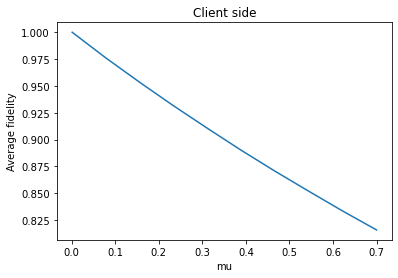

In [ ]:
plt.plot(mu_list, average_data, label = '')
plt.xlabel('mu')
plt.ylabel('Average fidelity')
plt.yscale('linear')
plt.xscale('linear')
plt.title('Client side') 

In [ ]:
average = []

In [ ]:
np.append(average, averphi0)

array([{0.0, 1.0}, {0.9759500000000001, 0.002016597794967225},
       {0.9533833333333334, 0.004044622894532245},
       {0.9315625000000001, 0.0050207901104640275},
       {0.910275, 0.007013448619506785},
       {0.8900666666666667, 0.008086709577749897},
       {0.8702916666666667, 0.01002880466840008},
       {0.8517125, 0.011024651863798193},
       {0.8336208333333334, 0.011038713925462755},
       {0.8153, 0.011711926859796854}], dtype=object)

In [ ]:
## Calculate averages
file_path = '/Users/azizasuleymanzade/Dropbox (Personal)/AzizaOnly/LukinLab/BlindComputing/SimulationCode_Aziza/SimulationCode/OutputFiles/BlindComputing/TableSingleGates_phi1_0.00_10pts_mu0.5_2024-05-01_23-47-59.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    print(line.strip())

parts = line.split('±')  # Split the string into parts

# Extract numbers from parts
mean = float(parts[0].strip())  # Convert the first part to float
std_dev = float(parts[1].strip())  # Convert the second part to float

print("Mean:", mean)
print("Standard Deviation:", std_dev)

X meas c      Y meas c      Z meas c      X meas s      Y meas s      Z meas s
+ X init   0.79 ± 0.00   0.00 ± 0.00   0.00 ± 0.00  -0.31 ± 0.77   0.00 ± 0.00   0.00 ± 0.00
- X init  -0.79 ± 0.01   0.00 ± 0.00   0.00 ± 0.00  -0.16 ± 0.82   0.00 ± 0.00   0.00 ± 0.00
+ Y init   0.00 ± 0.00   0.79 ± 0.00   0.00 ± 0.00   0.00 ± 0.00  -0.31 ± 0.77   0.00 ± 0.00
- Y init   0.00 ± 0.00  -0.80 ± 0.01   0.00 ± 0.00   0.00 ± 0.00  -0.16 ± 0.82   0.00 ± 0.00
+ Z init   0.00 ± 0.00   0.00 ± 0.00   1.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00   1.00 ± 0.00
- Z init   0.00 ± 0.00   0.00 ± 0.00  -1.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00  -1.00 ± 0.00


ValueError: could not convert string to float: '- Z init   0.00'

In [ ]:
xp_array[:, 1]

array([-0., -0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.])

In [ ]:
xp_array[:, 3]

array([-0.685, -0.685,  0.699, -0.685, -0.685, -0.685, -0.685,  0.699,
        0.699,  0.699])

In [ ]:
xp_array[:, 0]

array([0.685, 0.685, 0.699, 0.685, 0.685, 0.685, 0.685, 0.699, 0.699,
       0.699])